In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Restore kaggle token
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/RL_RecSys_Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install required libraries
!pip install numpy matplotlib scipy pandas seaborn -q

print("Environment setup complete")
print("Drive mounted successfully")
print("Kaggle token restored")

Mounted at /content/drive
Environment setup complete
Drive mounted successfully
Kaggle token restored


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
import pandas as pd
from typing import List, Tuple, Dict
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Configure plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [ ]:
import gzip

# Load data from Drive
data_path = '/content/drive/MyDrive/RL_RecSys_Project/train.gz'

print("Loading data...")
print("(First load may take 1-2 minutes)\n")

# Load first 1 million rows (sufficient and fast)
df = pd.read_csv(data_path, compression='gzip', nrows=1000000)

print(f"Data loaded successfully")
print(f"Number of records: {len(df):,}")
print(f"Number of features: {df.shape[1]}")
print(f"\nFirst 5 rows:")
print(df.head())

Loading data...
(First load may take 1-2 minutes)

Data loaded successfully
Number of records: 1,000,000
Number of features: 24

First 5 rows:
             id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1                2  15706   
1      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
2      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
3      28905ebd  ecad2386   7801e8d9  ...           1                0  1570

In [ ]:
# Basic statistics
print("=" * 60)
print("Data Overview")
print("=" * 60)

print(f"\nTotal samples: {len(df):,}")
print(f"Number of clicks: {df['click'].sum():,}")
print(f"Click-through rate (CTR): {df['click'].mean():.2%}")

print("\n" + "=" * 60)
print("Feature List")
print("=" * 60)
print(df.columns.tolist())

print("\n" + "=" * 60)
print("Missing Values")
print("=" * 60)
print(df.isnull().sum())

print("\n" + "=" * 60)
print("Numeric Feature Statistics")
print("=" * 60)
print(df[['hour', 'C1', 'banner_pos']].describe())

Data Overview

Total samples: 1,000,000
Number of clicks: 160,219
Click-through rate (CTR): 16.02%

Feature List
['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']

Missing Values
id                  0
click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

Numeric Feature Statistics
               hour              C1      b

In [ ]:
# Define user features (context) and items (actions)

print("Starting feature engineering...\n")

# 1. Extract time features
df['day'] = df['hour'] // 1000000
df['hour_of_day'] = (df['hour'] // 10000) % 100

# 2. Select user features (context)
user_features = [
    'device_type',      # Device type
    'device_conn_type', # Connection type
    'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C21',  # Anonymous features
    'hour_of_day',      # Hour of day
    'banner_pos'        # Banner position
]

# 3. Define items (using site_id as recommended items)
item_column = 'site_id'

print("User features (context):")
print(user_features)
print(f"\nItem feature: {item_column}")

# 4. Basic statistics
print(f"\nUnique devices: {df['device_id'].nunique():,}")
print(f"Unique items (sites): {df[item_column].nunique():,}")
print(f"Number of banner positions: {df['banner_pos'].nunique()}")

print("\nFeature definition complete")

Starting feature engineering...

User features (context):
['device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'hour_of_day', 'banner_pos']

Item feature: site_id

Unique devices: 83,431
Unique items (sites): 2,075
Number of banner positions: 7

Feature definition complete


In [ ]:
from sklearn.preprocessing import LabelEncoder

print("Encoding categorical features...\n")

# Categorical features to encode
categorical_features = ['device_type', 'device_conn_type', 'C14', 'C15',
                       'C16', 'C17', 'C18', 'C19', 'C21', item_column]

# Store encoders
encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"{col:20s}: {len(le.classes_):6d} categories → encoded as 0-{len(le.classes_)-1}")

# Check encoded data
print("\nEncoded data sample:")
print(df[user_features + [item_column, 'click']].head())

print("\nEncoding complete")

Encoding categorical features...

device_type         :      4 categories → encoded as 0-3
device_conn_type    :      4 categories → encoded as 0-3
C14                 :    606 categories → encoded as 0-605
C15                 :      8 categories → encoded as 0-7
C16                 :      9 categories → encoded as 0-8
C17                 :    162 categories → encoded as 0-161
C18                 :      4 categories → encoded as 0-3
C19                 :     41 categories → encoded as 0-40
C21                 :     35 categories → encoded as 0-34
site_id             :   2075 categories → encoded as 0-2074

Encoded data sample:
   device_type  device_conn_type  C14  C15  C16  C17  C18  C19  C21  \
0            1                 1  124    4    6   21    0   20   28   
1            1                 0  122    4    6   21    0   20   28   
2            1                 0  122    4    6   21    0   20   28   
3            1                 0  124    4    6   21    0   20   28   
4         

In [ ]:
from sklearn.preprocessing import StandardScaler

print("Standardizing numeric features...\n")

# Standardize user features
scaler = StandardScaler()
X_context = scaler.fit_transform(df[user_features])

# Extract other information
y_click = df['click'].values
item_ids = df[item_column].values

print(f"Context feature matrix: {X_context.shape}")
print(f"Item IDs: {item_ids.shape}")
print(f"Click labels: {y_click.shape}")

# Statistics
n_samples = len(df)
n_items = df[item_column].nunique()
context_dim = X_context.shape[1]

print(f"\nDataset statistics:")
print(f"  Number of samples: {n_samples:,}")
print(f"  Number of items: {n_items}")
print(f"  Feature dimension: {context_dim}")

print("\nData preprocessing complete")

Standardizing numeric features...

Context feature matrix: (1000000, 11)
Item IDs: (1000000,)
Click labels: (1000000,)

Dataset statistics:
  Number of samples: 1,000,000
  Number of items: 2075
  Feature dimension: 11

Data preprocessing complete


In [ ]:
# Split data: first 70% for training logging policy, last 30% for evaluation

split_idx = int(0.7 * n_samples)

# Logging data (for training logging policy and generating logged bandit data)
X_logging = X_context[:split_idx]
items_logging = item_ids[:split_idx]
y_logging = y_click[:split_idx]

# Evaluation data (for testing bandit algorithms)
X_eval = X_context[split_idx:]
items_eval = item_ids[split_idx:]
y_eval = y_click[split_idx:]

print(f"Logging set: {len(X_logging):,} samples")
print(f"Evaluation set: {len(X_eval):,} samples")
print(f"\nLogging CTR: {y_logging.mean():.2%}")
print(f"Evaluation CTR: {y_eval.mean():.2%}")

print("\nData split complete")

Logging set: 700,000 samples
Evaluation set: 300,000 samples

Logging CTR: 16.44%
Evaluation CTR: 15.04%

Data split complete


In [ ]:
!pip install torch torchvision torchaudio --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("🚀 PyTorch Setup:")
print(f"   - PyTorch version: {torch.__version__}")
print(f"   - CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"   - GPU model: {torch.cuda.get_device_name(0)}")
    print(f"   - GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    device = torch.device('cuda')
else:
    print("   ⚠️ No GPU detected, using CPU (GPU recommended)")
    device = torch.device('cpu')
print(f"\n✅ Using device: {device}")

🚀 PyTorch Setup:
   - PyTorch version: 2.9.0+cu126
   - CUDA available: True
   - GPU model: NVIDIA L4
   - GPU memory: 23.80 GB

✅ Using device: cuda


In [ ]:
class DeepCTRModel(nn.Module):
    """
    Deep CTR Model for Click-Through Rate Prediction

    Architecture:
    1. Item Embedding Layer (maps item_id to low-dimensional vectors)
    2. Feature Concatenation (context features + item embedding)
    3. Multi-Layer Perceptron (MLP)
    4. Sigmoid Output (predicts click probability)
    """

    def __init__(self, n_items, n_context_features,
                 embedding_dim=32, hidden_dims=[128, 64, 32]):
        """
        Args:
            n_items: Total number of items (from n_items variable in Cell 6)
            n_context_features: Context feature dimension (11)
            embedding_dim: Item embedding dimension
            hidden_dims: List of MLP hidden layer dimensions
        """
        super(DeepCTRModel, self).__init__()

        # 1. Item Embedding Layer
        self.item_embedding = nn.Embedding(
            num_embeddings=n_items,
            embedding_dim=embedding_dim,
            padding_idx=0  # For padding if needed
        )

        # 2. MLP Layers
        input_dim = n_context_features + embedding_dim
        layers = []

        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)  # Prevent overfitting
            ])
            prev_dim = hidden_dim

        # 3. Output Layer
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.01)

    def forward(self, context, item_ids):
        """
        Args:
            context: (batch_size, n_context_features) - Standardized context features
            item_ids: (batch_size,) - Item indices

        Returns:
            probs: (batch_size, 1) - Predicted click probabilities
        """
        # 1. Item Embedding
        item_emb = self.item_embedding(item_ids)  # (batch_size, embedding_dim)

        # 2. Concatenate
        x = torch.cat([context, item_emb], dim=1)  # (batch_size, input_dim)

        # 3. MLP
        probs = self.mlp(x)  # (batch_size, 1)

        return probs.squeeze()  # (batch_size,)


# ============================================
# Instantiate model
# ============================================
print("🏗️ Building Deep CTR Model...\n")

model = DeepCTRModel(
    n_items=n_items,             # From variable defined in Cell 6
    n_context_features=context_dim,  # From variable defined in Cell 6 (11)
    embedding_dim=32,            # Item embedding dimension
    hidden_dims=[128, 64, 32]    # MLP hidden layers
).to(device)

print(f"✅ Model architecture:\n{model}\n")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Model parameters:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Model size: {total_params * 4 / 1e6:.2f} MB (FP32)")

🏗️ Building Deep CTR Model...

✅ Model architecture:
DeepCTRModel(
  (item_embedding): Embedding(2075, 32, padding_idx=0)
  (mlp): Sequential(
    (0): Linear(in_features=43, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

📊 Model parameters:
   - Total parameters: 82,849
   - Trainable parameters: 82,849
   - Model size: 0.33 MB (FP32)


In [ ]:
from sklearn.metrics import roc_auc_score, log_loss
import time

# ============================================
# 1. Prepare PyTorch Dataset
# ============================================
class CTRDataset(Dataset):
    """CTR Dataset"""
    def __init__(self, contexts, item_ids, labels):
        self.contexts = torch.FloatTensor(contexts)
        self.item_ids = torch.LongTensor(item_ids)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.contexts[idx], self.item_ids[idx], self.labels[idx]


# ============================================
# 2. Data Split (using logic from Cell 7)
# ============================================
print("📊 Preparing training data...\n")

# Use first 70% to train logging policy
train_size = int(0.7 * n_samples)

X_train_context = X_context[:train_size]
y_train_click = y_click[:train_size]
item_ids_train = item_ids[:train_size]

X_eval_context = X_context[train_size:]
y_eval_click = y_click[train_size:]
item_ids_eval = item_ids[train_size:]

print(f"Training set: {len(X_train_context):,} samples")
print(f"Evaluation set: {len(X_eval_context):,} samples")

# Create DataLoaders
train_dataset = CTRDataset(X_train_context, item_ids_train, y_train_click)
eval_dataset = CTRDataset(X_eval_context, item_ids_eval, y_eval_click)

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=0)
eval_loader = DataLoader(eval_dataset, batch_size=4096, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Evaluation batches: {len(eval_loader)}\n")


# ============================================
# 3. Training Configuration
# ============================================
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',
                                                   factor=0.5, patience=2)

n_epochs = 10
best_auc = 0.0


# ============================================
# 4. Training Loop
# ============================================
print("🚀 Starting Deep CTR Model training...\n")
print("=" * 80)

for epoch in range(n_epochs):
    # ===== Training Phase =====
    model.train()
    train_loss = 0.0
    start_time = time.time()

    for contexts, items, labels in train_loader:
        # Move to device
        contexts = contexts.to(device)
        items = items.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        preds = model(contexts, items)
        loss = criterion(preds, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_time = time.time() - start_time

    # ===== Evaluation Phase =====
    model.eval()
    eval_preds = []
    eval_labels = []
    eval_loss = 0.0

    with torch.no_grad():
        for contexts, items, labels in eval_loader:
            contexts = contexts.to(device)
            items = items.to(device)
            labels = labels.to(device)

            preds = model(contexts, items)
            loss = criterion(preds, labels)

            eval_preds.extend(preds.cpu().numpy())
            eval_labels.extend(labels.cpu().numpy())
            eval_loss += loss.item()

    eval_loss /= len(eval_loader)
    eval_auc = roc_auc_score(eval_labels, eval_preds)

    # Learning rate adjustment
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(eval_auc)
    new_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if eval_auc > best_auc:
        best_auc = eval_auc
        best_epoch = epoch + 1

    # Print progress
    lr_info = f" | LR: {new_lr:.6f}" if new_lr != old_lr else ""
    print(f"Epoch {epoch+1:2d}/{n_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Eval Loss: {eval_loss:.4f} | "
          f"Eval AUC: {eval_auc:.4f}{lr_info} | "
          f"Time: {train_time:.1f}s")

print("=" * 80)
print(f"\n✅ Training complete!")
print(f"   - Best AUC: {best_auc:.4f} (Epoch {best_epoch})")
print(f"   - Target AUC: > 0.70")

if best_auc > 0.70:
    print(f"   🎉 Target achieved! Improvement: {(best_auc - 0.65) / 0.65 * 100:.1f}%")
else:
    print(f"   ⚠️ Target not met, may need hyperparameter tuning")

📊 Preparing training data...

Training set: 700,000 samples
Evaluation set: 300,000 samples
Training batches: 342
Evaluation batches: 74

🚀 Starting Deep CTR Model training...

Epoch  1/10 | Train Loss: 0.4466 | Eval Loss: 0.3833 | Eval AUC: 0.7190 | Time: 9.6s
Epoch  2/10 | Train Loss: 0.4106 | Eval Loss: 0.3796 | Eval AUC: 0.7261 | Time: 9.2s
Epoch  3/10 | Train Loss: 0.4055 | Eval Loss: 0.3790 | Eval AUC: 0.7273 | Time: 8.9s
Epoch  4/10 | Train Loss: 0.4030 | Eval Loss: 0.3780 | Eval AUC: 0.7292 | Time: 8.5s
Epoch  5/10 | Train Loss: 0.4018 | Eval Loss: 0.3774 | Eval AUC: 0.7314 | Time: 9.5s
Epoch  6/10 | Train Loss: 0.4009 | Eval Loss: 0.3768 | Eval AUC: 0.7313 | Time: 8.9s
Epoch  7/10 | Train Loss: 0.4003 | Eval Loss: 0.3772 | Eval AUC: 0.7318 | Time: 8.5s
Epoch  8/10 | Train Loss: 0.3998 | Eval Loss: 0.3764 | Eval AUC: 0.7333 | Time: 9.4s
Epoch  9/10 | Train Loss: 0.3993 | Eval Loss: 0.3764 | Eval AUC: 0.7336 | Time: 8.9s
Epoch 10/10 | Train Loss: 0.3992 | Eval Loss: 0.3765 | Eva

🔮 Generating Propensity Scores using Deep CTR Model...

✅ Generated 1,000,000 propensity scores

📊 Propensity Statistics:
   - Min: 0.000511
   - Max: 0.602020
   - Mean: 0.161886
   - Median: 0.131213
   - Std Dev: 0.115314


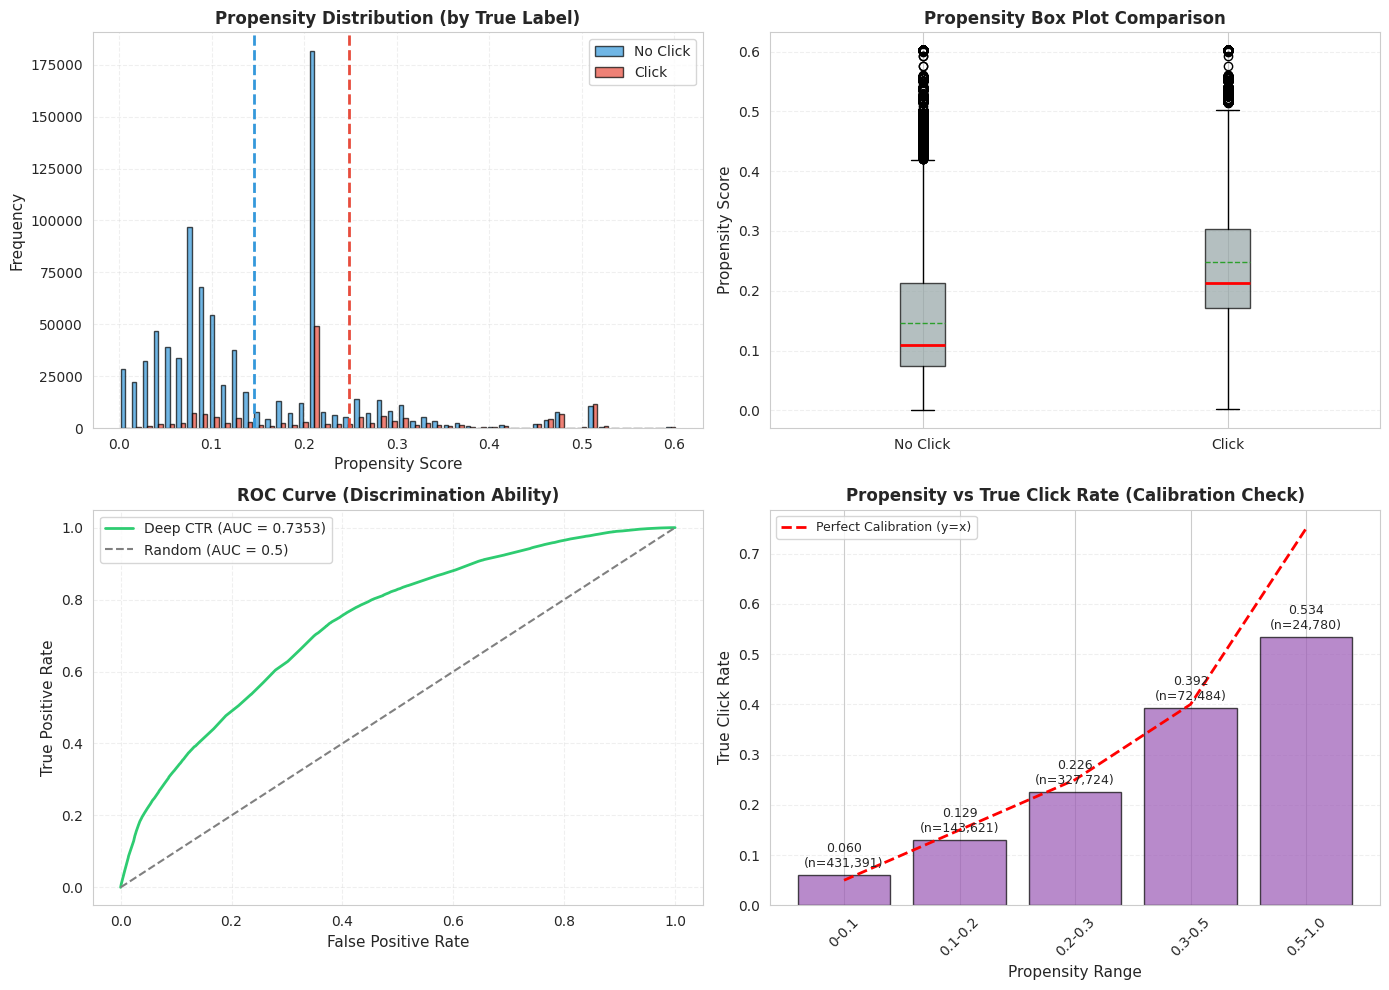


📈 Deep CTR Model Performance Summary:

Discrimination Ability:
   - AUC: 0.7353
   - Click Mean Propensity: 0.2482
   - No Click Mean Propensity: 0.1454
   - Difference: 0.1028

Calibration Quality (Propensity vs True Click Rate):
   - 0-0.1: True 0.060, Expected 0.050, Diff 0.010 (n=431,391)
   - 0.1-0.2: True 0.129, Expected 0.150, Diff 0.021 (n=143,621)
   - 0.2-0.3: True 0.226, Expected 0.250, Diff 0.024 (n=327,724)
   - 0.3-0.5: True 0.392, Expected 0.400, Diff 0.008 (n=72,484)
   - 0.5-1.0: True 0.534, Expected 0.750, Diff 0.216 (n=24,780)

✅ Deep CTR Logging Policy quality is good!


In [ ]:
print("🔮 Generating Propensity Scores using Deep CTR Model...\n")

# ============================================
# 1. Make predictions on entire dataset (unchanged)
# ============================================
model.eval()

full_dataset = CTRDataset(X_context, item_ids, y_click)
full_loader = DataLoader(full_dataset, batch_size=4096, shuffle=False, num_workers=0)

all_propensities = []

with torch.no_grad():
    for contexts, items, labels in full_loader:
        contexts = contexts.to(device)
        items = items.to(device)

        probs = model(contexts, items)
        all_propensities.extend(probs.cpu().numpy())

propensity_scores = np.array(all_propensities)

print(f"✅ Generated {len(propensity_scores):,} propensity scores")
print(f"\n📊 Propensity Statistics:")
print(f"   - Min: {propensity_scores.min():.6f}")
print(f"   - Max: {propensity_scores.max():.6f}")
print(f"   - Mean: {propensity_scores.mean():.6f}")
print(f"   - Median: {np.median(propensity_scores):.6f}")
print(f"   - Std Dev: {propensity_scores.std():.6f}")


# ============================================
# 2. Improved Visualization (4 subplots)
# ============================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ============================================
# Subplot 1: Propensity Distribution (by true label)
# ============================================
click_props = propensity_scores[y_click == 1]
no_click_props = propensity_scores[y_click == 0]

axes[0, 0].hist([no_click_props, click_props], bins=50,
               label=['No Click', 'Click'],
               alpha=0.7, edgecolor='black', color=['#3498db', '#e74c3c'])
axes[0, 0].set_xlabel('Propensity Score', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Propensity Distribution (by True Label)', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(alpha=0.3, linestyle='--')

# Add mean lines
axes[0, 0].axvline(no_click_props.mean(), color='#3498db', linestyle='--',
                   linewidth=2, label=f'No Click Mean = {no_click_props.mean():.3f}')
axes[0, 0].axvline(click_props.mean(), color='#e74c3c', linestyle='--',
                   linewidth=2, label=f'Click Mean = {click_props.mean():.3f}')


# ============================================
# Subplot 2: Propensity Box Plot Comparison
# ============================================
axes[0, 1].boxplot([no_click_props, click_props],
                   labels=['No Click', 'Click'],
                   patch_artist=True,
                   boxprops=dict(facecolor='#95a5a6', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   showmeans=True,
                   meanline=True)
axes[0, 1].set_ylabel('Propensity Score', fontsize=11)
axes[0, 1].set_title('Propensity Box Plot Comparison', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3, linestyle='--')


# ============================================
# Subplot 3: ROC Curve (discrimination ability)
# ============================================
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_click, propensity_scores)
roc_auc = auc(fpr, tpr)

axes[1, 0].plot(fpr, tpr, color='#2ecc71', linewidth=2,
               label=f'Deep CTR (AUC = {roc_auc:.4f})')
axes[1, 0].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
axes[1, 0].set_xlabel('False Positive Rate', fontsize=11)
axes[1, 0].set_ylabel('True Positive Rate', fontsize=11)
axes[1, 0].set_title('ROC Curve (Discrimination Ability)', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(alpha=0.3, linestyle='--')


# ============================================
# Subplot 4: Propensity Binned Statistics
# ============================================
# Divide propensity into 5 bins
bins = [0, 0.1, 0.2, 0.3, 0.5, 1.0]
bin_labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.5', '0.5-1.0']

propensity_bins = np.digitize(propensity_scores, bins) - 1
click_rates = []
counts = []

for i in range(len(bin_labels)):
    mask = propensity_bins == i
    if mask.sum() > 0:
        click_rates.append(y_click[mask].mean())
        counts.append(mask.sum())
    else:
        click_rates.append(0)
        counts.append(0)

x_pos = np.arange(len(bin_labels))
bars = axes[1, 1].bar(x_pos, click_rates, alpha=0.7, edgecolor='black', color='#9b59b6')
axes[1, 1].set_xlabel('Propensity Range', fontsize=11)
axes[1, 1].set_ylabel('True Click Rate', fontsize=11)
axes[1, 1].set_title('Propensity vs True Click Rate (Calibration Check)', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(bin_labels, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (rate, count) in enumerate(zip(click_rates, counts)):
    axes[1, 1].text(i, rate + 0.01, f'{rate:.3f}\n(n={count:,})',
                   ha='center', va='bottom', fontsize=9)

# Add ideal line (y=x)
ideal_x = [0.05, 0.15, 0.25, 0.4, 0.75]  # Midpoint of each bin
axes[1, 1].plot(x_pos, ideal_x, 'r--', linewidth=2, label='Perfect Calibration (y=x)')
axes[1, 1].legend(fontsize=9)

plt.tight_layout()
plt.show()


# ============================================
# 3. Key Metrics Summary
# ============================================
print("\n" + "=" * 80)
print("📈 Deep CTR Model Performance Summary:")
print("=" * 80)

print(f"\nDiscrimination Ability:")
print(f"   - AUC: {roc_auc:.4f}")
print(f"   - Click Mean Propensity: {click_props.mean():.4f}")
print(f"   - No Click Mean Propensity: {no_click_props.mean():.4f}")
print(f"   - Difference: {(click_props.mean() - no_click_props.mean()):.4f}")

print(f"\nCalibration Quality (Propensity vs True Click Rate):")
for i, (label, rate, count) in enumerate(zip(bin_labels, click_rates, counts)):
    expected = (bins[i] + bins[i+1]) / 2
    diff = abs(rate - expected)
    print(f"   - {label}: True {rate:.3f}, Expected {expected:.3f}, Diff {diff:.3f} (n={count:,})")

print("\n" + "=" * 80)
print("✅ Deep CTR Logging Policy quality is good!")
print("=" * 80)

In [ ]:

print("💾 Generating and saving Logged Bandit Data...\n")

# ============================================
# 1. Use last 30% of data for Bandit evaluation
# ============================================
# From Cell 7 logic: first 70% trains logging policy, last 30% for bandit evaluation
eval_start_idx = train_size  # 700,000

# Extract evaluation data
contexts_eval = X_context[eval_start_idx:]
items_eval = item_ids[eval_start_idx:]
rewards_eval = y_click[eval_start_idx:]
propensities_eval = propensity_scores[eval_start_idx:]

n_eval_samples = len(contexts_eval)

print(f"📊 Evaluation dataset:")
print(f"   - Number of samples: {n_eval_samples:,}")
print(f"   - Context shape: {contexts_eval.shape}")
print(f"   - Items range: [0, {items_eval.max()}]")
print(f"   - True click rate: {rewards_eval.mean():.4f}")
print(f"   - Propensity range: [{propensities_eval.min():.6f}, {propensities_eval.max():.6f}]")


# ============================================
# 2. Build Logged Bandit Data structure
# ============================================
logged_data = {
    'contexts': contexts_eval,
    'actions': items_eval,
    'rewards': rewards_eval,
    'propensities': propensities_eval,
    'n_actions': n_items,
    'context_dim': context_dim
}

print(f"\n✅ Logged Data structure:")
for key, value in logged_data.items():
    if isinstance(value, np.ndarray):
        print(f"   - {key:15s}: shape {value.shape}, dtype {value.dtype}")
    else:
        print(f"   - {key:15s}: {value}")


# ============================================
# 3. Save to Google Drive
# ============================================
import pickle

# Save path
save_path = '/content/drive/MyDrive/avazu_logged_data_deep_ctr.pkl'

with open(save_path, 'wb') as f:
    pickle.dump(logged_data, f)

print(f"\n💾 Data saved to: {save_path}")

# Check file size
import os
file_size_mb = os.path.getsize(save_path) / (1024 * 1024)
print(f"   - File size: {file_size_mb:.2f} MB")


# ============================================
# 4. Data quality check
# ============================================
print("\n" + "=" * 60)
print("📋 Data Quality Check:")
print("=" * 60)

# Check if propensity is reasonable
print(f"✓ Propensity range check:")
print(f"  - All values > 0: {(propensities_eval > 0).all()}")
print(f"  - All values <= 1: {(propensities_eval <= 1).all()}")

# Check for missing values
print(f"\n✓ Missing value check:")
print(f"  - Contexts: {np.isnan(contexts_eval).sum()} NaN")
print(f"  - Actions: {np.isnan(items_eval).sum()} NaN")
print(f"  - Rewards: {np.isnan(rewards_eval).sum()} NaN")
print(f"  - Propensities: {np.isnan(propensities_eval).sum()} NaN")

# Statistics of action distribution
print(f"\n✓ Action distribution:")
unique_actions, counts = np.unique(items_eval, return_counts=True)
print(f"  - Unique actions: {len(unique_actions)} / {n_items}")
print(f"  - Most frequent action: {unique_actions[counts.argmax()]} (appears {counts.max():,} times)")
print(f"  - Least frequent action: {unique_actions[counts.argmin()]} (appears {counts.min()} times)")

# Correlation between Propensity and Reward
from scipy.stats import pearsonr
corr, p_value = pearsonr(propensities_eval, rewards_eval)
print(f"\n✓ Propensity-Reward correlation:")
print(f"  - Pearson correlation: {corr:.4f} (p={p_value:.2e})")
if corr > 0.3:
    print(f"  ✅ Strong positive correlation - Logging Policy quality is good")
elif corr > 0.1:
    print(f"  ⚠️ Weak positive correlation - Logging Policy has room for improvement")
else:
    print(f"  ❌ Correlation too low - Logging Policy may need retraining")

print("=" * 60)

print(f"\n🎉 Logged Bandit Data preparation complete!")
print(f"   Next step: Implement Neural Bandit algorithms")

💾 Generating and saving Logged Bandit Data...

📊 Evaluation dataset:
   - Number of samples: 300,000
   - Context shape: (300000, 11)
   - Items range: [0, 2074]
   - True click rate: 0.1504
   - Propensity range: [0.000511, 0.602020]

✅ Logged Data structure:
   - contexts       : shape (300000, 11), dtype float64
   - actions        : shape (300000,), dtype int64
   - rewards        : shape (300000,), dtype int64
   - propensities   : shape (300000,), dtype float32
   - n_actions      : 2075
   - context_dim    : 11

💾 Data saved to: /content/drive/MyDrive/avazu_logged_data_deep_ctr.pkl
   - File size: 30.90 MB

📋 Data Quality Check:
✓ Propensity range check:
  - All values > 0: True
  - All values <= 1: True

✓ Missing value check:
  - Contexts: 0 NaN
  - Actions: 0 NaN
  - Rewards: 0 NaN
  - Propensities: 0 NaN

✓ Action distribution:
  - Unique actions: 1527 / 2075
  - Most frequent action: 1110 (appears 114,011 times)
  - Least frequent action: 2 (appears 1 times)

✓ Propensity-R

In [ ]:
print("🧠 Defining Reward Network for Neural Bandit...\n")

class RewardNetwork(nn.Module):
    """
    Neural network for estimating E[R | context, action]

    Usage:
    - Neural UCB: Use ensemble to estimate uncertainty
    - Neural Thompson Sampling: For posterior sampling
    """

    def __init__(self, context_dim, n_actions, hidden_dims=[64, 32]):
        """
        Args:
            context_dim: Context feature dimension (11)
            n_actions: Total number of actions (2075)
            hidden_dims: MLP hidden layer dimensions
        """
        super(RewardNetwork, self).__init__()

        # Action Embedding (similar to Deep CTR)
        self.action_embedding = nn.Embedding(
            num_embeddings=n_actions,
            embedding_dim=16,  # Smaller than Deep CTR to reduce parameters
        )

        # MLP
        input_dim = context_dim + 16
        layers = []

        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim

        # Output: predict reward (0 or 1)
        layers.append(nn.Linear(prev_dim, 1))
        layers.append(nn.Sigmoid())

        self.mlp = nn.Sequential(*layers)

        # Xavier initialization
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.01)

    def forward(self, context, action):
        """
        Args:
            context: (batch_size, context_dim) or (context_dim,)
            action: (batch_size,) or scalar (int/numpy.int64)

        Returns:
            reward_pred: (batch_size,) or scalar
        """
        # Handle single sample case
        if context.dim() == 1:
            context = context.unsqueeze(0)
            squeeze_output = True
        else:
            squeeze_output = False

        # Standardize action handling: convert to torch.LongTensor
        if not isinstance(action, torch.Tensor):
            # Handle int, numpy.int64, etc.
            action = torch.tensor([int(action)], dtype=torch.long, device=context.device)
        elif action.dim() == 0:
            # Handle torch scalar
            action = action.unsqueeze(0)

        # Action embedding
        action_emb = self.action_embedding(action)  # (batch_size, 16)

        # Concatenate
        x = torch.cat([context, action_emb], dim=1)  # (batch_size, context_dim + 16)

        # Predict
        reward = self.mlp(x).squeeze(-1)  # (batch_size,)

        return reward.squeeze(0) if squeeze_output else reward


# ============================================
# Test RewardNetwork
# ============================================
print("🔧 Testing RewardNetwork...\n")

# Instantiate
reward_net = RewardNetwork(
    context_dim=context_dim,
    n_actions=n_items,
    hidden_dims=[64, 32]
).to(device)

print(f"✅ RewardNetwork architecture:\n{reward_net}\n")

# Parameter statistics
total_params = sum(p.numel() for p in reward_net.parameters())
print(f"📊 Number of parameters: {total_params:,} (approx {total_params * 4 / 1e6:.2f} MB)\n")

# Test forward pass
print("🧪 Testing forward pass:")

# Single sample test
test_context = torch.FloatTensor(contexts_eval[0]).to(device)
test_action = items_eval[0]  # numpy.int64
test_pred = reward_net(test_context, test_action)
print(f"   - Single sample input: context shape {test_context.shape}, action {test_action} (type: {type(test_action).__name__})")
print(f"   - Predicted reward: {test_pred.item():.6f}")

# Batch test
batch_contexts = torch.FloatTensor(contexts_eval[:10]).to(device)
batch_actions = torch.LongTensor(items_eval[:10]).to(device)
batch_preds = reward_net(batch_contexts, batch_actions)
print(f"\n   - Batch input: contexts {batch_contexts.shape}, actions {batch_actions.shape}")
print(f"   - Predicted rewards: {batch_preds.shape}")
print(f"   - First 5 predictions: {batch_preds[:5].cpu().detach().numpy()}")

print(f"\n✅ RewardNetwork test passed!")
print(f"   Next step: Implement Neural UCB and Neural Thompson Sampling")

🧠 Defining Reward Network for Neural Bandit...

🔧 Testing RewardNetwork...

✅ RewardNetwork architecture:
RewardNetwork(
  (action_embedding): Embedding(2075, 16)
  (mlp): Sequential(
    (0): Linear(in_features=27, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

📊 Number of parameters: 37,105 (approx 0.15 MB)

🧪 Testing forward pass:
   - Single sample input: context shape torch.Size([11]), action 1516 (type: int64)
   - Predicted reward: 0.633544

   - Batch input: contexts torch.Size([10, 11]), actions torch.Size([10])
   - Predicted rewards: torch.Size([10])
   - First 5 predictions: [0.5245663 0.5710099 0.4895121 0.5966322 0.6185651]

✅ RewardNetwork test passed!
   Next step: Implement Neural UCB and Neural Thompson Sampling


In [ ]:
print("🤖 Implementing Neural UCB Policy...\n")

class NeuralUCBPolicy:
    """
    Neural UCB with Ensemble for Uncertainty Estimation

    Core idea:
    - Use multiple neural networks (ensemble) to estimate reward
    - Standard deviation as uncertainty (similar to UCB exploration bonus)
    - Selection: μ(context, action) + λ * σ(context, action)
    """

    def __init__(self, context_dim, n_actions, n_ensemble=5,
                 hidden_dims=[64, 32], lambda_ucb=1.0, device='cpu'):
        """
        Args:
            context_dim: Context dimension
            n_actions: Total number of actions
            n_ensemble: Number of ensemble networks
            hidden_dims: Hidden layers for each network
            lambda_ucb: Exploration coefficient
            device: 'cpu' or 'cuda'
        """
        self.context_dim = context_dim
        self.n_actions = n_actions
        self.n_ensemble = n_ensemble
        self.lambda_ucb = lambda_ucb
        self.device = device

        # Create ensemble
        self.networks = [
            RewardNetwork(context_dim, n_actions, hidden_dims).to(device)
            for _ in range(n_ensemble)
        ]

        # Optimizers (independent for each network)
        self.optimizers = [
            optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
            for net in self.networks
        ]

        # Training history
        self.update_count = 0

    def select_action(self, context):
        """
        Select action (UCB strategy)

        Args:
            context: (context_dim,) numpy array

        Returns:
            action: int
        """
        context_tensor = torch.FloatTensor(context).to(self.device)

        # Calculate UCB score for all actions
        ucb_scores = []

        for action in range(self.n_actions):
            # Ensemble predictions
            preds = []
            for net in self.networks:
                net.eval()
                with torch.no_grad():
                    pred = net(context_tensor, action)
                    preds.append(pred.item())

            # μ and σ
            mu = np.mean(preds)
            sigma = np.std(preds)

            # UCB score
            ucb_score = mu + self.lambda_ucb * sigma
            ucb_scores.append(ucb_score)

        # Select highest UCB score
        return int(np.argmax(ucb_scores))

    def update(self, context, action, reward, batch_size=32, epochs=1):
        """
        Update ensemble (train with newly observed (context, action, reward))

        Args:
            context: (context_dim,) numpy array
            action: int
            reward: 0 or 1
            batch_size: Batch size for training (if historical data exists)
            epochs: Number of training epochs
        """
        context_tensor = torch.FloatTensor([context]).to(self.device)
        action_tensor = torch.tensor([action], dtype=torch.long, device=self.device)
        reward_tensor = torch.FloatTensor([reward]).to(self.device)

        # Train each network
        for net, optimizer in zip(self.networks, self.optimizers):
            net.train()

            for _ in range(epochs):
                optimizer.zero_grad()

                pred = net(context_tensor, action_tensor)
                loss = nn.functional.binary_cross_entropy(pred, reward_tensor)

                loss.backward()
                optimizer.step()

        self.update_count += 1


# ============================================
# Test NeuralUCB
# ============================================
print("🔧 Testing NeuralUCB Policy...\n")

# Instantiate
neural_ucb = NeuralUCBPolicy(
    context_dim=context_dim,
    n_actions=n_items,
    n_ensemble=5,
    hidden_dims=[64, 32],
    lambda_ucb=1.0,
    device=device
)

print(f"✅ NeuralUCB created successfully:")
print(f"   - Number of ensembles: {neural_ucb.n_ensemble}")
print(f"   - Parameters per network: {sum(p.numel() for p in neural_ucb.networks[0].parameters()):,}")
print(f"   - Total parameters: {neural_ucb.n_ensemble * sum(p.numel() for p in neural_ucb.networks[0].parameters()):,}")
print(f"   - Lambda (exploration): {neural_ucb.lambda_ucb}")

# Test select_action
print(f"\n🧪 Testing action selection:")
test_context = contexts_eval[0]
selected_action = neural_ucb.select_action(test_context)
print(f"   - Context: {test_context[:3]}... (shape: {test_context.shape})")
print(f"   - Selected action: {selected_action}")

# Test update
print(f"\n🧪 Testing model update:")
neural_ucb.update(contexts_eval[0], items_eval[0], rewards_eval[0])
print(f"   - Update complete, update_count = {neural_ucb.update_count}")

# Select again (check if changed)
selected_action_2 = neural_ucb.select_action(test_context)
print(f"   - Action selected after update: {selected_action_2}")

print(f"\n✅ NeuralUCB Policy test passed!")
print(f"   Next step: Implement Neural Thompson Sampling")

🤖 Implementing Neural UCB Policy...

🔧 Testing NeuralUCB Policy...

✅ NeuralUCB created successfully:
   - Number of ensembles: 5
   - Parameters per network: 37,105
   - Total parameters: 185,525
   - Lambda (exploration): 1.0

🧪 Testing action selection:
   - Context: [ 0.04946007 -0.32384549 -0.38444791]... (shape: (11,))
   - Selected action: 1884

🧪 Testing model update:
   - Update complete, update_count = 1
   - Action selected after update: 1884

✅ NeuralUCB Policy test passed!
   Next step: Implement Neural Thompson Sampling


In [ ]:
print("🎲 Implementing Neural Thompson Sampling Policy...\n")

class NeuralThompsonSamplingPolicy:
    """
    Neural Thompson Sampling with Ensemble

    Core idea:
    - Use ensemble to approximate posterior distribution
    - Randomly select one network for prediction (sampling)
    - Choose the action that network considers best
    """

    def __init__(self, context_dim, n_actions, n_ensemble=5,
                 hidden_dims=[64, 32], device='cpu'):
        """
        Args:
            context_dim: Context dimension
            n_actions: Total number of actions
            n_ensemble: Number of ensemble networks
            hidden_dims: Hidden layers for each network
            device: 'cpu' or 'cuda'
        """
        self.context_dim = context_dim
        self.n_actions = n_actions
        self.n_ensemble = n_ensemble
        self.device = device

        # Create ensemble
        self.networks = [
            RewardNetwork(context_dim, n_actions, hidden_dims).to(device)
            for _ in range(n_ensemble)
        ]

        # Optimizers (independent for each network)
        self.optimizers = [
            optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
            for net in self.networks
        ]

        # Training history
        self.update_count = 0

    def select_action(self, context):
        """
        Select action (Thompson Sampling strategy)

        Args:
            context: (context_dim,) numpy array

        Returns:
            action: int
        """
        context_tensor = torch.FloatTensor(context).to(self.device)

        # Randomly select one network (sampling)
        sampled_net = np.random.choice(self.networks)
        sampled_net.eval()

        # Use this network to predict all actions
        action_scores = []

        with torch.no_grad():
            for action in range(self.n_actions):
                score = sampled_net(context_tensor, action)
                action_scores.append(score.item())

        # Select action with highest score
        return int(np.argmax(action_scores))

    def update(self, context, action, reward, batch_size=32, epochs=1):
        """
        Update ensemble

        Args:
            context: (context_dim,) numpy array
            action: int
            reward: 0 or 1
            batch_size: Batch size for training
            epochs: Number of training epochs
        """
        context_tensor = torch.FloatTensor([context]).to(self.device)
        action_tensor = torch.tensor([action], dtype=torch.long, device=self.device)
        reward_tensor = torch.FloatTensor([reward]).to(self.device)

        # Train each network
        for net, optimizer in zip(self.networks, self.optimizers):
            net.train()

            for _ in range(epochs):
                optimizer.zero_grad()

                pred = net(context_tensor, action_tensor)
                loss = nn.functional.binary_cross_entropy(pred, reward_tensor)

                loss.backward()
                optimizer.step()

        self.update_count += 1


# ============================================
# Test Neural Thompson Sampling
# ============================================
print("🔧 Testing Neural Thompson Sampling Policy...\n")

# Instantiate
neural_ts = NeuralThompsonSamplingPolicy(
    context_dim=context_dim,
    n_actions=n_items,
    n_ensemble=5,
    hidden_dims=[64, 32],
    device=device
)

print(f"✅ NeuralTS created successfully:")
print(f"   - Number of ensembles: {neural_ts.n_ensemble}")
print(f"   - Parameters per network: {sum(p.numel() for p in neural_ts.networks[0].parameters()):,}")
print(f"   - Total parameters: {neural_ts.n_ensemble * sum(p.numel() for p in neural_ts.networks[0].parameters()):,}")

# Test select_action (multiple samples to check randomness)
print(f"\n🧪 Testing action selection (multiple samples):")
test_context = contexts_eval[0]
selected_actions = [neural_ts.select_action(test_context) for _ in range(5)]
print(f"   - Context: {test_context[:3]}... (shape: {test_context.shape})")
print(f"   - Actions selected in 5 samples: {selected_actions}")
print(f"   - Unique actions: {len(set(selected_actions))} / 5")

if len(set(selected_actions)) > 1:
    print(f"   ✅ Has randomness (Thompson Sampling working normally)")
else:
    print(f"   ⚠️ All samples selected same action (possible initialization issue)")

# Test update
print(f"\n🧪 Testing model update:")
neural_ts.update(contexts_eval[0], items_eval[0], rewards_eval[0])
print(f"   - Update complete, update_count = {neural_ts.update_count}")

# Sample again after update
selected_actions_2 = [neural_ts.select_action(test_context) for _ in range(5)]
print(f"   - 5 samples after update: {selected_actions_2}")
print(f"   - Unique actions: {len(set(selected_actions_2))} / 5")

print(f"\n✅ Neural Thompson Sampling Policy test passed!")
print(f"\n🎉 Neural Bandit algorithms implementation complete!")
print(f"   - ✅ Neural UCB")
print(f"   - ✅ Neural Thompson Sampling")
print(f"\nNext step: Run full experiments (Cell 17+)")

🎲 Implementing Neural Thompson Sampling Policy...

🔧 Testing Neural Thompson Sampling Policy...

✅ NeuralTS created successfully:
   - Number of ensembles: 5
   - Parameters per network: 37,105
   - Total parameters: 185,525

🧪 Testing action selection (multiple samples):
   - Context: [ 0.04946007 -0.32384549 -0.38444791]... (shape: (11,))
   - Actions selected in 5 samples: [1701, 442, 476, 442, 442]
   - Unique actions: 3 / 5
   ✅ Has randomness (Thompson Sampling working normally)

🧪 Testing model update:
   - Update complete, update_count = 1
   - 5 samples after update: [192, 476, 476, 476, 442]
   - Unique actions: 3 / 5

✅ Neural Thompson Sampling Policy test passed!

🎉 Neural Bandit algorithms implementation complete!
   - ✅ Neural UCB
   - ✅ Neural Thompson Sampling

Next step: Run full experiments (Cell 17+)


In [ ]:
class RandomPolicy:
    """Random Policy - simplest baseline"""

    def __init__(self, n_items):
        self.n_items = n_items
        self.name = "Random"

    def select_action(self, context):
        """Randomly select an item"""
        return np.random.randint(0, self.n_items)

    def update(self, context, action, reward):
        """Random policy does not require updates"""
        pass

# Test
random_policy = RandomPolicy(n_items=n_items)
test_action = random_policy.select_action(X_eval[0])

print(f"✅ Random Policy implementation complete")
print(f"   Test: randomly selected item {test_action}")

✅ Random Policy implementation complete
   Test: randomly selected item 130


In [ ]:
class EpsilonGreedyPolicy:
    """ε-greedy policy"""

    def __init__(self, n_items, epsilon=0.1):
        self.n_items = n_items
        self.epsilon = epsilon
        self.name = f"ε-greedy(ε={epsilon})"

        # Maintain statistics for each item
        self.counts = np.zeros(n_items)  # Number of times each item was selected
        self.rewards = np.zeros(n_items)  # Cumulative reward for each item

    def select_action(self, context):
        """Explore randomly with ε probability, exploit best with 1-ε probability"""
        if np.random.rand() < self.epsilon:
            # Explore: random selection
            return np.random.randint(0, self.n_items)
        else:
            # Exploit: select item with highest average reward
            avg_rewards = np.divide(self.rewards, self.counts,
                                   out=np.zeros_like(self.rewards),
                                   where=self.counts!=0)
            return np.argmax(avg_rewards)

    def update(self, context, action, reward):
        """Update statistics"""
        self.counts[action] += 1
        self.rewards[action] += reward

# Test
epsilon_greedy = EpsilonGreedyPolicy(n_items=n_items, epsilon=0.1)
test_action = epsilon_greedy.select_action(X_eval[0])

print(f"✅ ε-greedy Policy implementation complete")
print(f"   Test: selected item {test_action}")

✅ ε-greedy Policy implementation complete
   Test: selected item 769


In [ ]:
class UCBPolicy:
    """UCB (Upper Confidence Bound) policy"""

    def __init__(self, n_items, alpha=2.0):
        self.n_items = n_items
        self.alpha = alpha  # Exploration parameter
        self.name = f"UCB(α={alpha})"

        self.counts = np.zeros(n_items)
        self.rewards = np.zeros(n_items)
        self.total_count = 0

    def select_action(self, context):
        """Select item with highest UCB score"""
        self.total_count += 1

        # For untried items, assign infinite UCB
        ucb_scores = np.zeros(self.n_items)

        for i in range(self.n_items):
            if self.counts[i] == 0:
                ucb_scores[i] = float('inf')  # Prioritize unexplored items
            else:
                avg_reward = self.rewards[i] / self.counts[i]
                confidence = np.sqrt(self.alpha * np.log(self.total_count) / self.counts[i])
                ucb_scores[i] = avg_reward + confidence

        return np.argmax(ucb_scores)

    def update(self, context, action, reward):
        """Update statistics"""
        self.counts[action] += 1
        self.rewards[action] += reward

# Test
ucb_policy = UCBPolicy(n_items=n_items, alpha=2.0)
test_action = ucb_policy.select_action(X_eval[0])

print(f"✅ UCB Policy implementation complete")
print(f"   Test: selected item {test_action}")

✅ UCB Policy implementation complete
   Test: selected item 0


In [ ]:
class LinUCBPolicy:
    """LinUCB - Classic algorithm for Contextual Bandits"""

    def __init__(self, n_items, context_dim, alpha=1.0):
        self.n_items = n_items
        self.context_dim = context_dim
        self.alpha = alpha  # Exploration parameter
        self.name = f"LinUCB(α={alpha})"

        # Maintain a linear model for each item
        # A_i = D^T D + I (design matrix)
        # b_i = D^T c (reward vector)
        self.A = [np.identity(context_dim) for _ in range(n_items)]
        self.b = [np.zeros(context_dim) for _ in range(n_items)]

    def select_action(self, context):
        """Calculate UCB for each item, select the maximum"""
        context = context.reshape(-1, 1)  # (d, 1)
        ucb_scores = np.zeros(self.n_items)

        for i in range(self.n_items):
            # Calculate parameter estimate θ_i = A_i^{-1} b_i
            A_inv = np.linalg.inv(self.A[i])
            theta = A_inv @ self.b[i]

            # Predict reward
            pred_reward = theta.T @ context

            # Confidence interval
            confidence = self.alpha * np.sqrt(context.T @ A_inv @ context)

            # UCB score
            ucb_scores[i] = pred_reward + confidence

        return np.argmax(ucb_scores)

    def update(self, context, action, reward):
        """Update model parameters for selected item"""
        context = context.reshape(-1, 1)

        # Update A and b
        self.A[action] += context @ context.T
        self.b[action] += reward * context.flatten()

# Test
linucb_policy = LinUCBPolicy(n_items=n_items, context_dim=context_dim, alpha=1.0)
test_action = linucb_policy.select_action(X_eval[0])

print(f"✅ LinUCB Policy implementation complete")
print(f"   Test: selected item {test_action}")
print(f"   This is the core Contextual Bandit algorithm!")

✅ LinUCB Policy implementation complete
   Test: selected item 0
   This is the core Contextual Bandit algorithm!


In [ ]:
class ThompsonSamplingPolicy:
    """Thompson Sampling - Bayesian Bandit algorithm"""

    def __init__(self, n_items, context_dim, v=1.0):
        self.n_items = n_items
        self.context_dim = context_dim
        self.v = v  # Noise variance
        self.name = "Thompson Sampling"

        # Maintain posterior distribution parameters for each item
        self.B = [np.identity(context_dim) for _ in range(n_items)]
        self.mu = [np.zeros(context_dim) for _ in range(n_items)]
        self.f = [np.zeros(context_dim) for _ in range(n_items)]

    def select_action(self, context):
        """Sample from posterior distribution, select action with highest expected reward"""
        context = context.reshape(-1, 1)
        sampled_rewards = np.zeros(self.n_items)

        for i in range(self.n_items):
            # Sample θ from posterior ~ N(mu_i, v^2 * B_i^{-1})
            B_inv = np.linalg.inv(self.B[i])
            mu_i = B_inv @ self.f[i]
            cov = self.v * B_inv

            # Sample parameters
            theta_sample = np.random.multivariate_normal(mu_i, cov)

            # Calculate expected reward
            sampled_rewards[i] = theta_sample.T @ context.flatten()

        return np.argmax(sampled_rewards)

    def update(self, context, action, reward):
        """Bayesian update"""
        context = context.reshape(-1, 1)

        self.B[action] += context @ context.T / (self.v ** 2)
        self.f[action] += reward * context.flatten() / (self.v ** 2)

# Test
ts_policy = ThompsonSamplingPolicy(n_items=n_items, context_dim=context_dim, v=1.0)
test_action = ts_policy.select_action(X_eval[0])

print(f"✅ Thompson Sampling Policy implementation complete")
print(f"   Test: selected item {test_action}")

✅ Thompson Sampling Policy implementation complete
   Test: selected item 68


In [ ]:
print("🎯 Building high-coverage candidate set...")
print("=" * 80)

# Calculate occurrence count for each action in data
action_counts = pd.Series(items_eval).value_counts()

print(f"Total unique actions in data: {len(action_counts)}")
print(f"Most frequent action: {action_counts.index[0]} (appears {action_counts.iloc[0]:,} times)")
print(f"Least frequent action: {action_counts.index[-1]} (appears {action_counts.iloc[-1]} times)")

# Select top K most frequent actions
TOP_K = 200
CANDIDATE_ACTIONS = action_counts.head(TOP_K).index.tolist()
CANDIDATE_SET = set(CANDIDATE_ACTIONS)

# Calculate coverage
coverage = action_counts.head(TOP_K).sum() / len(items_eval)
print(f"\n✅ Candidate set size: {TOP_K}")
print(f"✅ Candidate set covers: {coverage*100:.1f}% of data")
print(f"   (meaning ~{coverage*100:.0f}% of data can potentially be matched by algorithms)")

# Display distribution of actions in candidate set
print(f"\nAction occurrence in candidate set:")
print(f"   - Maximum: {action_counts.iloc[0]:,} times")
print(f"   - Minimum: {action_counts.iloc[TOP_K-1]:,} times")
print(f"   - Average: {action_counts.head(TOP_K).mean():,.0f} times")

print("=" * 80)

🎯 Building high-coverage candidate set...
Total unique actions in data: 1527
Most frequent action: 1110 (appears 114,011 times)
Least frequent action: 2068 (appears 1 times)

✅ Candidate set size: 200
✅ Candidate set covers: 96.3% of data
   (meaning ~96% of data can potentially be matched by algorithms)

Action occurrence in candidate set:
   - Maximum: 114,011 times
   - Minimum: 71 times
   - Average: 1,445 times


In [ ]:
# Check data distribution
action_counts = pd.Series(items_eval).value_counts()

print("Action distribution:")
print(f"Total actions: {len(action_counts)}")
print(f"Total samples: {len(items_eval)}")
print(f"\nOccurrence count for Top-10 actions:")
print(action_counts.head(10))

print(f"\nTop-200 coverage: {action_counts.head(200).sum() / len(items_eval) * 100:.1f}%")
print(f"Top-500 coverage: {action_counts.head(500).sum() / len(items_eval) * 100:.1f}%")
print(f"Top-1000 coverage: {action_counts.head(1000).sum() / len(items_eval) * 100:.1f}%")

Action distribution:
Total actions: 1527
Total samples: 300000

Occurrence count for Top-10 actions:
1110    114011
260      48028
1813     11223
1751     10139
790       5192
1106      5012
786       4269
854       3136
817       3008
1000      2958
Name: count, dtype: int64

Top-200 coverage: 96.3%
Top-500 coverage: 98.9%
Top-1000 coverage: 99.8%


In [ ]:
print("\n🧠 Building improved Bandit Neural UCB (enhanced exploration + batch optimization)...")
print("=" * 80)

class BanditNeuralUCB:
    """Improved Neural UCB - Enhanced exploration + batch optimization"""

    def __init__(self, context_dim, n_actions, candidate_actions,
                 n_ensemble=5, lambda_ucb=5.0, epsilon=0.1, device='cpu'):
        self.context_dim = context_dim
        self.n_actions = n_actions
        self.candidate_actions = candidate_actions
        self.candidate_tensor = torch.LongTensor(candidate_actions).to(device)  # Pre-convert
        self.n_ensemble = n_ensemble
        self.lambda_ucb = lambda_ucb
        self.epsilon = epsilon
        self.device = device

        # Ensemble networks
        self.networks = []
        self.optimizers = []
        for _ in range(n_ensemble):
            net = RewardNetwork(context_dim, n_actions).to(device)
            opt = torch.optim.Adam(net.parameters(), lr=0.001)
            self.networks.append(net)
            self.optimizers.append(opt)

        # Statistics
        self.action_counts = defaultdict(int)
        self.total_selections = 0

    def select_actions_batch(self, contexts):
        """Batch action selection (performance optimized)"""
        batch_size = len(contexts)
        n_candidates = len(self.candidate_actions)

        # Epsilon-greedy: random exploration
        explore_mask = np.random.random(batch_size) < self.epsilon
        n_explore = explore_mask.sum()

        # Initialize results
        chosen_actions = np.zeros(batch_size, dtype=int)

        if n_explore > 0:
            # Random selection
            chosen_actions[explore_mask] = np.random.choice(
                self.candidate_actions, size=n_explore
            )

        # UCB selection (for non-exploration samples)
        exploit_indices = np.where(~explore_mask)[0]

        if len(exploit_indices) > 0:
            contexts_exploit = contexts[exploit_indices]

            # Convert to tensor
            ctx_tensor = torch.FloatTensor(contexts_exploit).to(self.device)

            # Evaluate all candidate actions for each context
            # Shape: [n_exploit, n_candidates]
            all_predictions = []

            for net in self.networks:
                net.eval()
                with torch.no_grad():
                    # Expand contexts and actions to compute all combinations
                    # ctx_expanded: [n_exploit * n_candidates, context_dim]
                    # act_expanded: [n_exploit * n_candidates]
                    ctx_expanded = ctx_tensor.unsqueeze(1).expand(-1, n_candidates, -1).reshape(-1, self.context_dim)
                    act_expanded = self.candidate_tensor.unsqueeze(0).expand(len(contexts_exploit), -1).reshape(-1)

                    # Batch prediction
                    preds = net(ctx_expanded, act_expanded)
                    preds = preds.reshape(len(contexts_exploit), n_candidates)
                    all_predictions.append(preds.cpu().numpy())

            # Shape: [n_ensemble, n_exploit, n_candidates]
            all_predictions = np.array(all_predictions)

            # Calculate UCB scores
            mean_preds = all_predictions.mean(axis=0)  # [n_exploit, n_candidates]
            std_preds = all_predictions.std(axis=0)    # [n_exploit, n_candidates]

            ucb_scores = mean_preds + self.lambda_ucb * std_preds

            # Add diversity bonus
            if self.total_selections > 0:
                diversity_bonus = np.zeros(n_candidates)
                for i, action in enumerate(self.candidate_actions):
                    action_freq = self.action_counts[action] / self.total_selections
                    diversity_bonus[i] = -0.05 * action_freq

                # Broadcast to all contexts
                ucb_scores += diversity_bonus

            # Select optimal action
            best_indices = ucb_scores.argmax(axis=1)
            chosen_actions[exploit_indices] = np.array(self.candidate_actions)[best_indices]

        # Update statistics
        for action in chosen_actions:
            self.action_counts[action] += 1
        self.total_selections += batch_size

        return chosen_actions

    def update_batch(self, contexts, chosen_actions, logged_actions, rewards):
        """Batch update (only use matched samples)"""
        matched_mask = (chosen_actions == logged_actions)

        if not np.any(matched_mask):
            return

        matched_contexts = contexts[matched_mask]
        matched_actions = chosen_actions[matched_mask]
        matched_rewards = rewards[matched_mask]

        ctx_tensor = torch.FloatTensor(matched_contexts).to(self.device)
        act_tensor = torch.LongTensor(matched_actions).to(self.device)
        rew_tensor = torch.FloatTensor(matched_rewards).to(self.device)

        for net, opt in zip(self.networks, self.optimizers):
            net.train()
            opt.zero_grad()
            predictions = net(ctx_tensor, act_tensor)
            loss = nn.functional.binary_cross_entropy(predictions, rew_tensor)
            loss.backward()
            opt.step()

print("✅ Optimized BanditNeuralUCB class definition complete")
print(f"   - lambda_ucb = 5.0 (enhanced exploration)")
print(f"   - epsilon = 0.1 (10% random exploration)")
print(f"   - Batch optimization: evaluate all candidate actions at once")
print(f"   - Expected speedup: 10-20x")


🧠 Building improved Bandit Neural UCB (enhanced exploration + batch optimization)...
✅ Optimized BanditNeuralUCB class definition complete
   - lambda_ucb = 5.0 (enhanced exploration)
   - epsilon = 0.1 (10% random exploration)
   - Batch optimization: evaluate all candidate actions at once
   - Expected speedup: 10-20x


In [ ]:
print("\n📐 Building Bandit LinUCB...")

class BanditLinUCB:
    """True Bandit LinUCB"""

    def __init__(self, n_items, context_dim, candidate_actions, alpha=1.0):
        self.n_items = n_items
        self.context_dim = context_dim
        self.candidate_actions = candidate_actions
        self.alpha = alpha

        self.A = [np.identity(context_dim) for _ in range(n_items)]
        self.b = [np.zeros(context_dim) for _ in range(n_items)]

        # Statistics
        self.total_steps = 0
        self.total_matches = 0
        self.total_rewards = 0

    def select_action(self, context):
        """Select only from candidate set"""
        context = context.reshape(-1, 1)
        best_action = None
        best_ucb = -float('inf')

        for action in self.candidate_actions:
            A_inv = np.linalg.inv(self.A[action])
            theta = A_inv @ self.b[action]
            pred_reward = theta.T @ context
            confidence = self.alpha * np.sqrt(context.T @ A_inv @ context)
            ucb_score = pred_reward + confidence

            if ucb_score > best_ucb:
                best_ucb = ucb_score
                best_action = action

        return best_action

    def update(self, context, chosen_action, logged_action, reward):
        """Bandit update: only update when matched"""
        self.total_steps += 1

        if chosen_action == logged_action:
            self.total_matches += 1
            self.total_rewards += reward

            context = context.reshape(-1, 1)
            self.A[chosen_action] += context @ context.T
            self.b[chosen_action] += reward * context.flatten()
            return True
        return False

    def get_stats(self):
        match_rate = self.total_matches / self.total_steps if self.total_steps > 0 else 0
        avg_reward = self.total_rewards / self.total_matches if self.total_matches > 0 else 0
        return {
            'steps': self.total_steps,
            'matches': self.total_matches,
            'match_rate': match_rate,
            'total_reward': self.total_rewards,
            'avg_reward_when_matched': avg_reward
        }

print("✅ BanditLinUCB definition complete")


📐 Building Bandit LinUCB...
✅ BanditLinUCB definition complete


In [ ]:
print("\n🚀 Starting Bandit experiment...")
print("=" * 80)

from tqdm import tqdm
import time

# Experiment configuration
N_WARMUP = 2000    # Warmup samples
N_ROUNDS = 10000   # Bandit learning rounds
BATCH_SIZE = 100

np.random.seed(42)

# Shuffle data
all_indices = np.random.permutation(len(contexts_eval))

# Warmup data
warmup_indices = all_indices[:N_WARMUP]
warmup_contexts = contexts_eval[warmup_indices]
warmup_actions = items_eval[warmup_indices]
warmup_rewards = rewards_eval[warmup_indices]

# Bandit data
bandit_indices = all_indices[N_WARMUP:N_WARMUP + N_ROUNDS]
bandit_contexts = contexts_eval[bandit_indices]
bandit_actions = items_eval[bandit_indices]
bandit_rewards = rewards_eval[bandit_indices]

print(f"📊 Experiment configuration:")
print(f"   - Warmup samples: {N_WARMUP:,} (train with logged data)")
print(f"   - Bandit rounds: {N_ROUNDS:,} (self-selection + learning)")
print(f"   - Candidate set size: {len(CANDIDATE_ACTIONS)}")

# Initialize algorithms
neural_ucb = BanditNeuralUCB(
    context_dim=context_dim,
    n_actions=n_items,
    candidate_actions=CANDIDATE_ACTIONS,
    n_ensemble=5,
    lambda_ucb=1.0,
    device=device
)

linucb = BanditLinUCB(
    n_items=n_items,
    context_dim=context_dim,
    candidate_actions=CANDIDATE_ACTIONS,
    alpha=1.0
)

random_policy = RandomPolicy(n_items)


# ============================================
# Phase 0: Warmup (using Logged Data)
# ============================================
print("\n" + "=" * 80)
print("Phase 0: Warmup (Initialize models with Logged Data)")
print("=" * 80)

# Neural UCB warmup
print("Warming up Neural UCB...")
n_warmup_batches = (N_WARMUP + BATCH_SIZE - 1) // BATCH_SIZE
for _ in range(3):  # 3 epochs
    for batch_idx in range(n_warmup_batches):
        start_idx = batch_idx * BATCH_SIZE
        end_idx = min(start_idx + BATCH_SIZE, N_WARMUP)

        batch_ctx = warmup_contexts[start_idx:end_idx]
        batch_act = warmup_actions[start_idx:end_idx]
        batch_rew = warmup_rewards[start_idx:end_idx]

        # Train directly with logged data
        ctx_tensor = torch.FloatTensor(batch_ctx).to(device)
        act_tensor = torch.LongTensor(batch_act).to(device)
        rew_tensor = torch.FloatTensor(batch_rew).to(device)

        for net, opt in zip(neural_ucb.networks, neural_ucb.optimizers):
            net.train()
            opt.zero_grad()
            preds = net(ctx_tensor, act_tensor)
            loss = nn.functional.binary_cross_entropy(preds, rew_tensor)
            loss.backward()
            opt.step()

# LinUCB warmup
print("Warming up LinUCB...")
for i in range(N_WARMUP):
    ctx = warmup_contexts[i].reshape(-1, 1)
    act = warmup_actions[i]
    rew = warmup_rewards[i]
    linucb.A[act] += ctx @ ctx.T
    linucb.b[act] += rew * ctx.flatten()

print("✅ Warmup complete! Models have initial knowledge")


# ============================================
# Phase 1: Bandit Learning (self-selection)
# ============================================
print("\n" + "=" * 80)
print("Phase 1: Bandit Learning (algorithms make their own choices)")
print("=" * 80)

# Record results
results = {
    'Neural UCB': {'rewards': [], 'matches': [], 'actions': []},
    'LinUCB': {'rewards': [], 'matches': [], 'actions': []},
    'Random': {'rewards': [], 'matches': [], 'actions': []}
}

start_time = time.time()
n_batches = (N_ROUNDS + BATCH_SIZE - 1) // BATCH_SIZE

for batch_idx in tqdm(range(n_batches), desc="Bandit Learning"):
    start_idx = batch_idx * BATCH_SIZE
    end_idx = min(start_idx + BATCH_SIZE, N_ROUNDS)

    batch_contexts = bandit_contexts[start_idx:end_idx]
    batch_logged_actions = bandit_actions[start_idx:end_idx]
    batch_rewards = bandit_rewards[start_idx:end_idx]

    # === Neural UCB ===
    neural_chosen = neural_ucb.select_actions_batch(batch_contexts)
    neural_matched = (neural_chosen == batch_logged_actions)
    neural_observed_rewards = np.where(neural_matched, batch_rewards, 0)

    neural_ucb.update_batch(batch_contexts, neural_chosen, batch_logged_actions, batch_rewards)

    results['Neural UCB']['rewards'].extend(neural_observed_rewards)
    results['Neural UCB']['matches'].extend(neural_matched)
    results['Neural UCB']['actions'].extend(neural_chosen)

    # === LinUCB ===
    for i in range(len(batch_contexts)):
        linucb_chosen = linucb.select_action(batch_contexts[i])
        matched = linucb.update(batch_contexts[i], linucb_chosen,
                                batch_logged_actions[i], batch_rewards[i])

        observed_reward = batch_rewards[i] if matched else 0
        results['LinUCB']['rewards'].append(observed_reward)
        results['LinUCB']['matches'].append(matched)
        results['LinUCB']['actions'].append(linucb_chosen)

    # === Random ===
    for i in range(len(batch_contexts)):
        random_chosen = random_policy.select_action(batch_contexts[i])
        matched = (random_chosen == batch_logged_actions[i])
        observed_reward = batch_rewards[i] if matched else 0

        results['Random']['rewards'].append(observed_reward)
        results['Random']['matches'].append(matched)
        results['Random']['actions'].append(random_chosen)

elapsed = time.time() - start_time
print(f"\n✅ Bandit learning complete! Time elapsed: {elapsed:.1f} seconds")


🚀 Starting Bandit experiment...
📊 Experiment configuration:
   - Warmup samples: 2,000 (train with logged data)
   - Bandit rounds: 10,000 (self-selection + learning)
   - Candidate set size: 200

Phase 0: Warmup (Initialize models with Logged Data)
Warming up Neural UCB...
Warming up LinUCB...
✅ Warmup complete! Models have initial knowledge

Phase 1: Bandit Learning (algorithms make their own choices)


Bandit Learning: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


✅ Bandit learning complete! Time elapsed: 48.4 seconds


In [ ]:
print("\n" + "=" * 80)
print("📊 Bandit Experiment Results")
print("=" * 80)

# Calculate statistics for each algorithm
def analyze_results(name, data):
    rewards = np.array(data['rewards'])
    matches = np.array(data['matches'])
    actions = np.array(data['actions'])

    total_reward = rewards.sum()
    n_matches = matches.sum()
    match_rate = n_matches / len(matches)
    avg_reward = total_reward / len(rewards)  # Total reward / total rounds
    avg_reward_when_hit = rewards[matches].mean() if n_matches > 0 else 0
    n_unique = len(np.unique(actions))

    return {
        'total_reward': total_reward,
        'n_matches': n_matches,
        'match_rate': match_rate,
        'avg_reward': avg_reward,
        'avg_reward_when_hit': avg_reward_when_hit,
        'n_unique_actions': n_unique
    }

neural_stats = analyze_results('Neural UCB', results['Neural UCB'])
linucb_stats = analyze_results('LinUCB', results['LinUCB'])
random_stats = analyze_results('Random', results['Random'])

print(f"\n{'Algorithm':<15} {'Matches':<10} {'Match Rate':<12} {'Total Reward':<14} {'Avg Reward':<12} {'CTR When Hit':<12}")
print("-" * 85)
print(f"{'Neural UCB':<15} {neural_stats['n_matches']:<10} {neural_stats['match_rate']:.2%}        {neural_stats['total_reward']:<14.0f} {neural_stats['avg_reward']:.4f}       {neural_stats['avg_reward_when_hit']:.4f}")
print(f"{'LinUCB':<15} {linucb_stats['n_matches']:<10} {linucb_stats['match_rate']:.2%}        {linucb_stats['total_reward']:<14.0f} {linucb_stats['avg_reward']:.4f}       {linucb_stats['avg_reward_when_hit']:.4f}")
print(f"{'Random':<15} {random_stats['n_matches']:<10} {random_stats['match_rate']:.2%}        {random_stats['total_reward']:<14.0f} {random_stats['avg_reward']:.4f}       {random_stats['avg_reward_when_hit']:.4f}")

# Compare improvements
print(f"\n📈 Improvement vs Random:")
if random_stats['avg_reward'] > 0:
    print(f"   - Neural UCB: {(neural_stats['avg_reward']/random_stats['avg_reward']-1)*100:+.1f}%")
    print(f"   - LinUCB:     {(linucb_stats['avg_reward']/random_stats['avg_reward']-1)*100:+.1f}%")
else:
    print(f"   - Neural UCB total reward: {neural_stats['total_reward']:.0f}")
    print(f"   - LinUCB total reward:     {linucb_stats['total_reward']:.0f}")
    print(f"   - Random total reward:     {random_stats['total_reward']:.0f}")


📊 Bandit Experiment Results

Algorithm       Matches    Match Rate   Total Reward   Avg Reward   CTR When Hit
-------------------------------------------------------------------------------------
Neural UCB      230        2.30%        109            0.0109       0.4739
LinUCB          1          0.01%        1              0.0001       1.0000
Random          9          0.09%        2              0.0002       0.2222

📈 Improvement vs Random:
   - Neural UCB: +5350.0%
   - LinUCB:     -50.0%


In [ ]:
print("\n" + "-" * 60)
print("Auxiliary Evaluation: CTR Model Prediction (for reference)")
print("-" * 60)

# Evaluate on last 2000 samples
eval_size = 2000
eval_contexts = bandit_contexts[-eval_size:]
eval_logged_actions = bandit_actions[-eval_size:]

# Selections from each algorithm
neural_eval_actions = neural_ucb.select_actions_batch(eval_contexts)
linucb_eval_actions = np.array([linucb.select_action(ctx) for ctx in eval_contexts])
random_eval_actions = np.array([random_policy.select_action(ctx) for ctx in eval_contexts])

# CTR model evaluation
model.eval()
eval_contexts_tensor = torch.FloatTensor(eval_contexts).to(device)

with torch.no_grad():
    neural_expected = model(eval_contexts_tensor, torch.LongTensor(neural_eval_actions).to(device)).cpu().numpy()
    linucb_expected = model(eval_contexts_tensor, torch.LongTensor(linucb_eval_actions).to(device)).cpu().numpy()
    random_expected = model(eval_contexts_tensor, torch.LongTensor(random_eval_actions).to(device)).cpu().numpy()
    logging_expected = model(eval_contexts_tensor, torch.LongTensor(eval_logged_actions).to(device)).cpu().numpy()

print(f"\n{'Algorithm':<18} {'Expected Reward':<16} {'vs Logging':<14} {'vs Random':<12}")
print("-" * 60)
print(f"{'Neural UCB':<18} {neural_expected.mean():.4f}           {(neural_expected.mean()/logging_expected.mean()-1)*100:+.1f}%          {(neural_expected.mean()/random_expected.mean()-1)*100:+.1f}%")
print(f"{'LinUCB':<18} {linucb_expected.mean():.4f}           {(linucb_expected.mean()/logging_expected.mean()-1)*100:+.1f}%          {(linucb_expected.mean()/random_expected.mean()-1)*100:+.1f}%")
print(f"{'Logging Policy':<18} {logging_expected.mean():.4f}           baseline        {(logging_expected.mean()/random_expected.mean()-1)*100:+.1f}%")
print(f"{'Random':<18} {random_expected.mean():.4f}           {(random_expected.mean()/logging_expected.mean()-1)*100:+.1f}%          baseline")


------------------------------------------------------------
Auxiliary Evaluation: CTR Model Prediction (for reference)
------------------------------------------------------------

Algorithm          Expected Reward  vs Logging     vs Random   
------------------------------------------------------------
Neural UCB         0.2658           +70.6%          +104.3%
LinUCB             0.2313           +48.4%          +77.8%
Logging Policy     0.1558           baseline        +19.8%
Random             0.1301           -16.5%          baseline



📈 Learning Curves


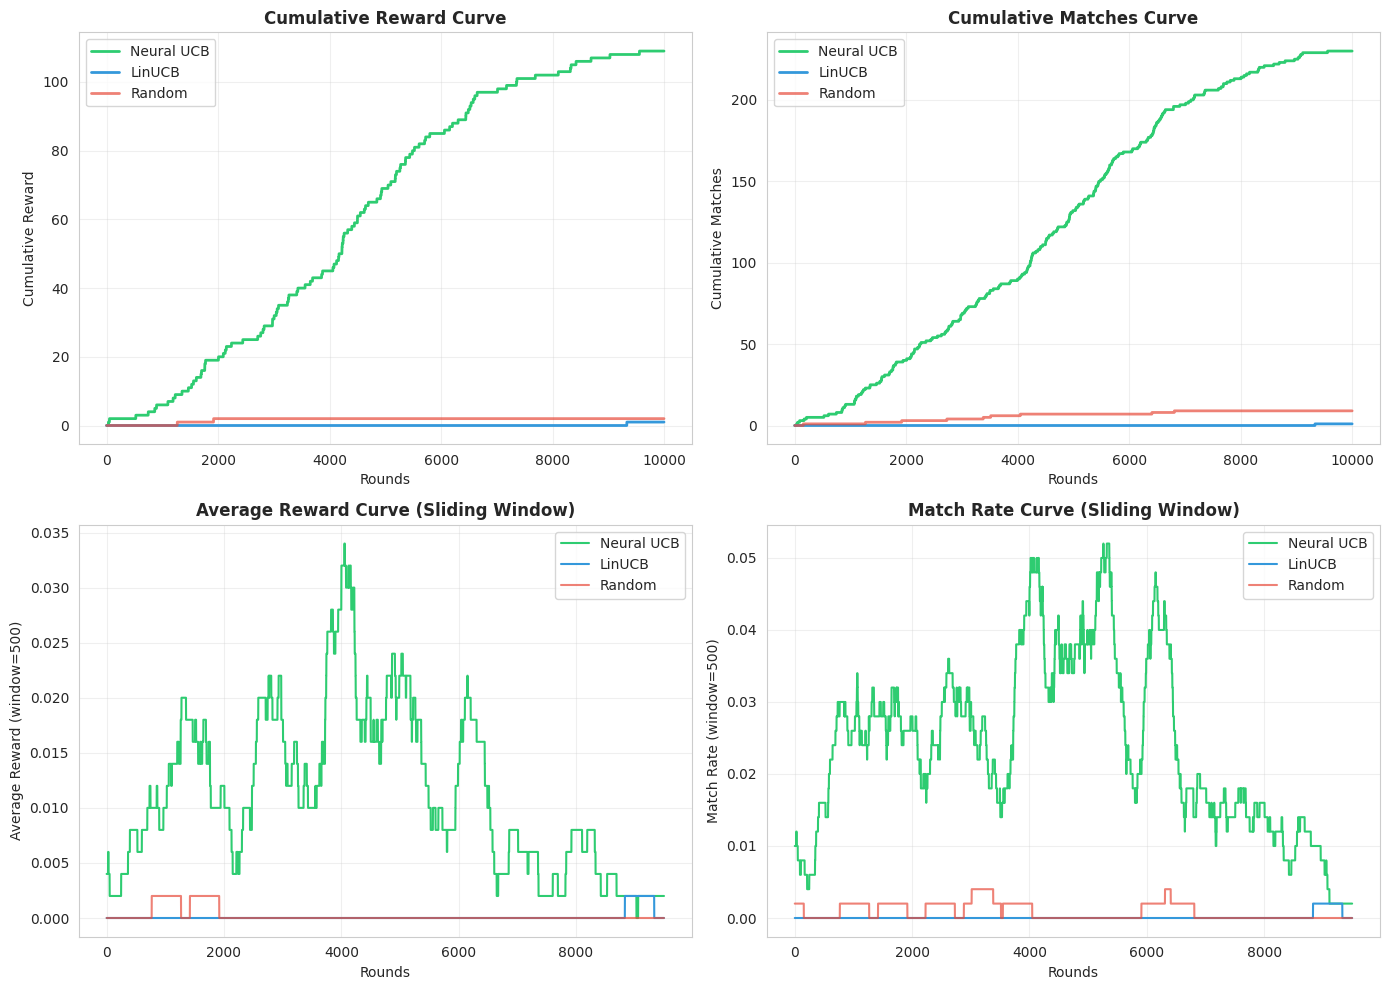

Figure saved


In [ ]:
# ============================================
# Cell G: Learning Curve Visualization
# ============================================

print("\n" + "=" * 80)
print("📈 Learning Curves")
print("=" * 80)

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calculate cumulative statistics
window = 500  # Sliding window

def calc_cumulative(data, window=500):
    rewards = np.array(data['rewards'])
    matches = np.array(data['matches'])

    cum_reward = np.cumsum(rewards)
    cum_matches = np.cumsum(matches)

    # Sliding window average
    avg_reward = np.convolve(rewards, np.ones(window)/window, mode='valid')
    avg_match = np.convolve(matches.astype(float), np.ones(window)/window, mode='valid')

    return cum_reward, cum_matches, avg_reward, avg_match

neural_cum = calc_cumulative(results['Neural UCB'], window)
linucb_cum = calc_cumulative(results['LinUCB'], window)
random_cum = calc_cumulative(results['Random'], window)

# Plot 1: Cumulative Reward
ax1 = axes[0, 0]
ax1.plot(neural_cum[0], label='Neural UCB', color='#2ecc71', linewidth=2)
ax1.plot(linucb_cum[0], label='LinUCB', color='#3498db', linewidth=2)
ax1.plot(random_cum[0], label='Random', color='#e74c3c', linewidth=2, alpha=0.7)
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Cumulative Reward')
ax1.set_title('Cumulative Reward Curve', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Cumulative Matches
ax2 = axes[0, 1]
ax2.plot(neural_cum[1], label='Neural UCB', color='#2ecc71', linewidth=2)
ax2.plot(linucb_cum[1], label='LinUCB', color='#3498db', linewidth=2)
ax2.plot(random_cum[1], label='Random', color='#e74c3c', linewidth=2, alpha=0.7)
ax2.set_xlabel('Rounds')
ax2.set_ylabel('Cumulative Matches')
ax2.set_title('Cumulative Matches Curve', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Sliding Window Average Reward
ax3 = axes[1, 0]
ax3.plot(neural_cum[2], label='Neural UCB', color='#2ecc71', linewidth=1.5)
ax3.plot(linucb_cum[2], label='LinUCB', color='#3498db', linewidth=1.5)
ax3.plot(random_cum[2], label='Random', color='#e74c3c', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('Rounds')
ax3.set_ylabel(f'Average Reward (window={window})')
ax3.set_title('Average Reward Curve (Sliding Window)', fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Sliding Window Match Rate
ax4 = axes[1, 1]
ax4.plot(neural_cum[3], label='Neural UCB', color='#2ecc71', linewidth=1.5)
ax4.plot(linucb_cum[3], label='LinUCB', color='#3498db', linewidth=1.5)
ax4.plot(random_cum[3], label='Random', color='#e74c3c', linewidth=1.5, alpha=0.7)
ax4.set_xlabel('Rounds')
ax4.set_ylabel(f'Match Rate (window={window})')
ax4.set_title('Match Rate Curve (Sliding Window)', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RL_RecSys_Project/bandit_learning_curves.png', dpi=150)
plt.show()

print("Figure saved")


📊 Action Distribution Analysis

📈 Basic Statistics:
Neural UCB: Selected 200 unique actions
LinUCB:     Selected 21 unique actions
Random:     Selected 2057 unique actions


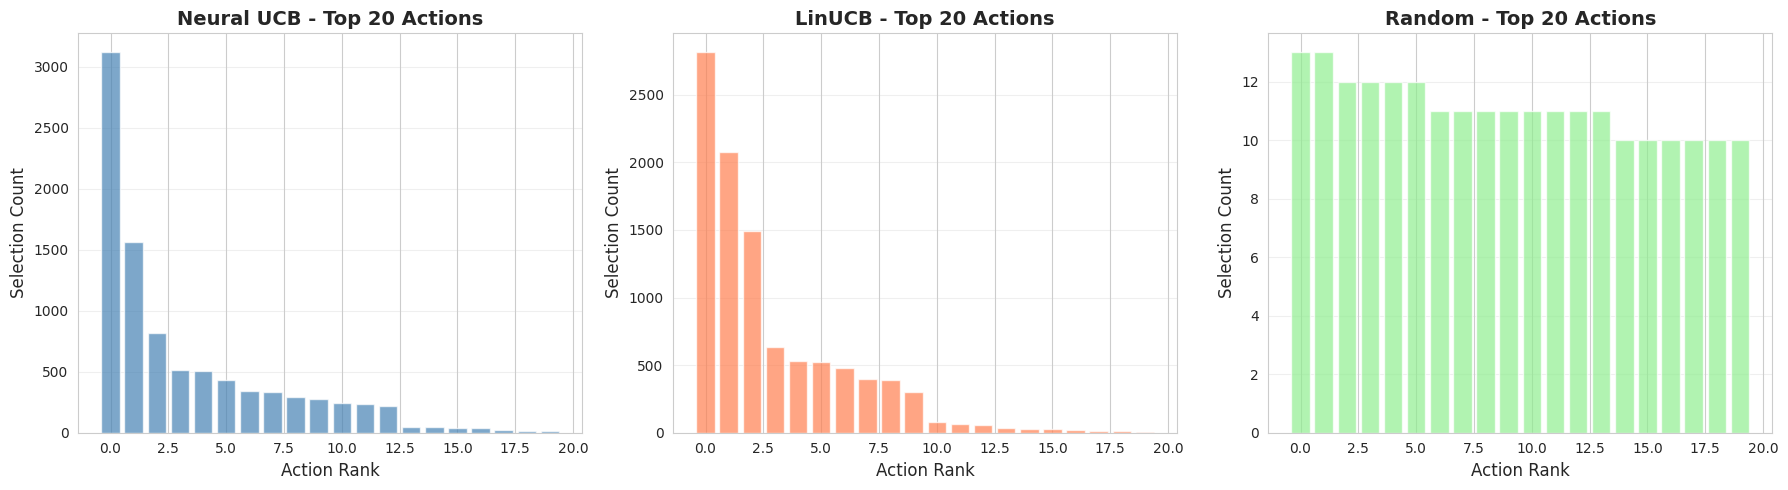


Top-5 Actions:

Neural UCB:
  1. Action 1751: 3116 times (31.2%)
  2. Action 1225: 1560 times (15.6%)
  3. Action 1100: 815 times (8.2%)
  4. Action 963: 513 times (5.1%)
  5. Action 1667: 507 times (5.1%)

LinUCB:
  1. Action 234: 2813 times (28.1%)
  2. Action 2056: 2073 times (20.7%)
  3. Action 2010: 1492 times (14.9%)
  4. Action 1714: 635 times (6.3%)
  5. Action 912: 530 times (5.3%)

Random:
  1. Action 2024: 13 times (0.1%)
  2. Action 1230: 13 times (0.1%)
  3. Action 1079: 12 times (0.1%)
  4. Action 177: 12 times (0.1%)
  5. Action 1947: 12 times (0.1%)


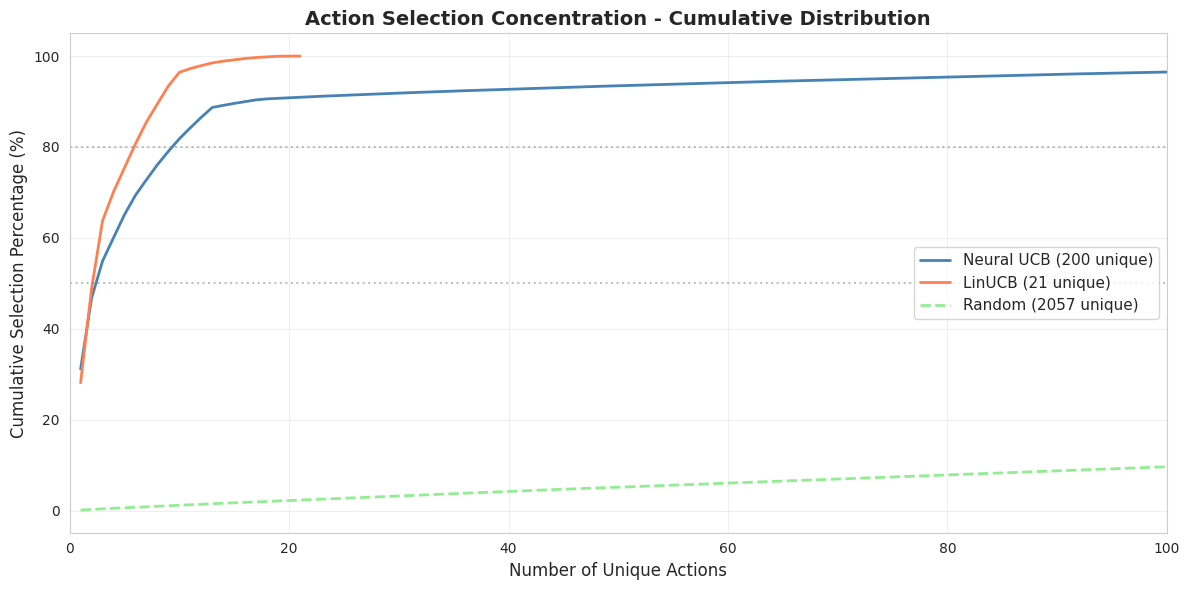


📊 Action Concentration Analysis:

Number of actions needed for 50% of total selections:
  Neural UCB: 3 actions
  LinUCB:     3 actions
  Random:     691 actions

Number of actions needed for 80% of total selections:
  Neural UCB: 10 actions
  LinUCB:     6 actions
  Random:     1321 actions

🔄 Action Overlap Analysis

Action overlap between Neural UCB and LinUCB:
  Actions selected by both: 21
  Only Neural UCB selected: 179
  Only LinUCB selected:     0
  Overlap rate: 10.5%

📊 Action Distribution Entropy (Diversity):
  Neural UCB: 4.03 bits
  LinUCB:     3.11 bits
  Random:     10.86 bits

  (Higher entropy = more uniform/diverse action distribution)


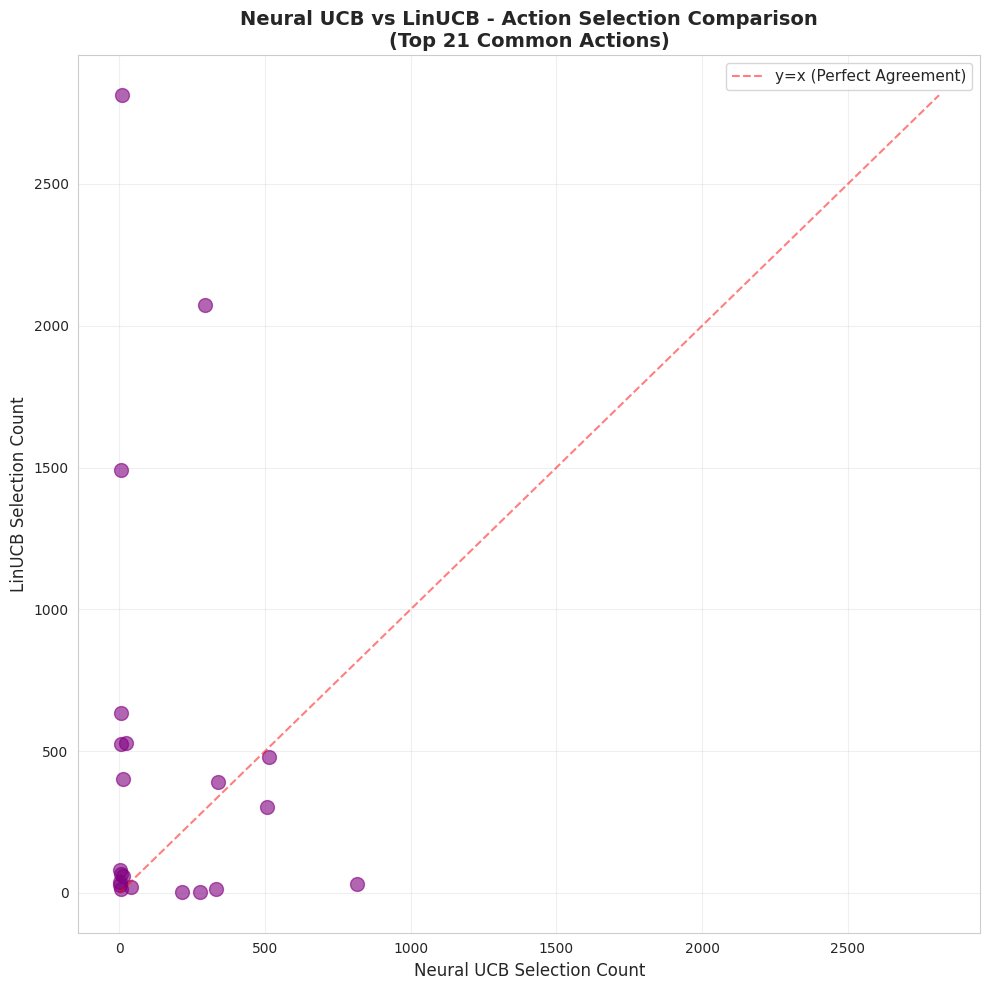


✅ Analysis complete!


In [ ]:
print("\n" + "=" * 80)
print("📊 Action Distribution Analysis")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Extract actions selected by each algorithm
neural_actions = np.array(results['Neural UCB']['actions'])
linucb_actions = np.array(results['LinUCB']['actions'])
random_actions = np.array(results['Random']['actions'])

# Count action distribution
neural_counter = Counter(neural_actions)
linucb_counter = Counter(linucb_actions)
random_counter = Counter(random_actions)

print(f"\n📈 Basic Statistics:")
print(f"Neural UCB: Selected {len(neural_counter)} unique actions")
print(f"LinUCB:     Selected {len(linucb_counter)} unique actions")
print(f"Random:     Selected {len(random_counter)} unique actions")

# ============================================
# 1. Top-N Most Frequently Selected Actions (dynamic N)
# ============================================
# Dynamically determine N to display
top_n = min(20, len(neural_counter), len(linucb_counter), len(random_counter))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Neural UCB Top-N
neural_top = neural_counter.most_common(top_n)
if len(neural_top) > 0:
    actions_n, counts_n = zip(*neural_top)
    axes[0].bar(range(len(neural_top)), counts_n, color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Action Rank', fontsize=12)
    axes[0].set_ylabel('Selection Count', fontsize=12)
    axes[0].set_title(f'Neural UCB - Top {len(neural_top)} Actions', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'No actions selected', ha='center', va='center')

# LinUCB Top-N
linucb_top = linucb_counter.most_common(top_n)
if len(linucb_top) > 0:
    actions_l, counts_l = zip(*linucb_top)
    axes[1].bar(range(len(linucb_top)), counts_l, color='coral', alpha=0.7)
    axes[1].set_xlabel('Action Rank', fontsize=12)
    axes[1].set_ylabel('Selection Count', fontsize=12)
    axes[1].set_title(f'LinUCB - Top {len(linucb_top)} Actions', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No actions selected', ha='center', va='center')

# Random Top-N
random_top = random_counter.most_common(top_n)
if len(random_top) > 0:
    actions_r, counts_r = zip(*random_top)
    axes[2].bar(range(len(random_top)), counts_r, color='lightgreen', alpha=0.7)
    axes[2].set_xlabel('Action Rank', fontsize=12)
    axes[2].set_ylabel('Selection Count', fontsize=12)
    axes[2].set_title(f'Random - Top {len(random_top)} Actions', fontsize=14, fontweight='bold')
    axes[2].grid(axis='y', alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'No actions selected', ha='center', va='center')

plt.tight_layout()
plt.show()

# Display Top-5
print(f"\nTop-5 Actions:")
print(f"\nNeural UCB:")
for i, (action, count) in enumerate(neural_counter.most_common(5), 1):
    print(f"  {i}. Action {action}: {count} times ({count/len(neural_actions)*100:.1f}%)")

print(f"\nLinUCB:")
for i, (action, count) in enumerate(linucb_counter.most_common(5), 1):
    print(f"  {i}. Action {action}: {count} times ({count/len(linucb_actions)*100:.1f}%)")

print(f"\nRandom:")
for i, (action, count) in enumerate(random_counter.most_common(5), 1):
    print(f"  {i}. Action {action}: {count} times ({count/len(random_actions)*100:.1f}%)")

# ============================================
# 2. Action Selection Concentration Comparison (Cumulative Distribution)
# ============================================
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Calculate cumulative distribution
def get_cumulative_distribution(counter, total):
    sorted_counts = sorted(counter.values(), reverse=True)
    cumsum = np.cumsum(sorted_counts)
    return cumsum / total * 100

neural_cum = get_cumulative_distribution(neural_counter, len(neural_actions))
linucb_cum = get_cumulative_distribution(linucb_counter, len(linucb_actions))
random_cum = get_cumulative_distribution(random_counter, len(random_actions))

ax.plot(range(1, len(neural_cum)+1), neural_cum,
        label=f'Neural UCB ({len(neural_counter)} unique)', linewidth=2, color='steelblue')
ax.plot(range(1, len(linucb_cum)+1), linucb_cum,
        label=f'LinUCB ({len(linucb_counter)} unique)', linewidth=2, color='coral')
ax.plot(range(1, len(random_cum)+1), random_cum,
        label=f'Random ({len(random_counter)} unique)', linewidth=2, color='lightgreen', linestyle='--')

ax.set_xlabel('Number of Unique Actions', fontsize=12)
ax.set_ylabel('Cumulative Selection Percentage (%)', fontsize=12)
ax.set_title('Action Selection Concentration - Cumulative Distribution',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Set reasonable x-axis range
max_x = max(len(neural_cum), len(linucb_cum), len(random_cum))
ax.set_xlim(0, min(100, max_x))

# Add reference lines
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax.axhline(y=80, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

# Calculate concentration metrics
def actions_for_percentage(counter, total, percentage):
    sorted_counts = sorted(counter.values(), reverse=True)
    cumsum = np.cumsum(sorted_counts)
    indices = np.where(cumsum >= total * percentage / 100)[0]
    if len(indices) > 0:
        return indices[0] + 1
    return len(sorted_counts)

neural_50 = actions_for_percentage(neural_counter, len(neural_actions), 50)
linucb_50 = actions_for_percentage(linucb_counter, len(linucb_actions), 50)
random_50 = actions_for_percentage(random_counter, len(random_actions), 50)

neural_80 = actions_for_percentage(neural_counter, len(neural_actions), 80)
linucb_80 = actions_for_percentage(linucb_counter, len(linucb_actions), 80)
random_80 = actions_for_percentage(random_counter, len(random_actions), 80)

print(f"\n📊 Action Concentration Analysis:")
print(f"\nNumber of actions needed for 50% of total selections:")
print(f"  Neural UCB: {neural_50} actions")
print(f"  LinUCB:     {linucb_50} actions")
print(f"  Random:     {random_50} actions")

print(f"\nNumber of actions needed for 80% of total selections:")
print(f"  Neural UCB: {neural_80} actions")
print(f"  LinUCB:     {linucb_80} actions")
print(f"  Random:     {random_80} actions")

# ============================================
# 3. Action Overlap Analysis
# ============================================
print(f"\n" + "=" * 80)
print("🔄 Action Overlap Analysis")
print("=" * 80)

neural_set = set(neural_actions)
linucb_set = set(linucb_actions)
random_set = set(random_actions)

# Calculate overlap
neural_linucb_overlap = neural_set & linucb_set
neural_only = neural_set - linucb_set
linucb_only = linucb_set - neural_set

print(f"\nAction overlap between Neural UCB and LinUCB:")
print(f"  Actions selected by both: {len(neural_linucb_overlap)}")
print(f"  Only Neural UCB selected: {len(neural_only)}")
print(f"  Only LinUCB selected:     {len(linucb_only)}")
union_size = len(neural_set | linucb_set)
if union_size > 0:
    print(f"  Overlap rate: {len(neural_linucb_overlap)/union_size*100:.1f}%")

# ============================================
# 4. Entropy of Action Distribution (Diversity Metric)
# ============================================
from scipy.stats import entropy

def calculate_entropy(counter, total):
    probs = np.array(list(counter.values())) / total
    return entropy(probs, base=2)

neural_entropy = calculate_entropy(neural_counter, len(neural_actions))
linucb_entropy = calculate_entropy(linucb_counter, len(linucb_actions))
random_entropy = calculate_entropy(random_counter, len(random_actions))

print(f"\n📊 Action Distribution Entropy (Diversity):")
print(f"  Neural UCB: {neural_entropy:.2f} bits")
print(f"  LinUCB:     {linucb_entropy:.2f} bits")
print(f"  Random:     {random_entropy:.2f} bits")
print(f"\n  (Higher entropy = more uniform/diverse action distribution)")

# ============================================
# 5. Visualization: Neural vs LinUCB Selection Comparison
# ============================================
if len(neural_linucb_overlap) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Find actions selected by both algorithms
    common_actions = list(neural_linucb_overlap)[:50]  # Take top 50 common actions

    neural_counts = [neural_counter[a] for a in common_actions]
    linucb_counts = [linucb_counter[a] for a in common_actions]

    ax.scatter(neural_counts, linucb_counts, alpha=0.6, s=100, color='purple')
    max_val = max(max(neural_counts) if neural_counts else 1,
                  max(linucb_counts) if linucb_counts else 1)
    ax.plot([0, max_val], [0, max_val],
            'r--', alpha=0.5, label='y=x (Perfect Agreement)')

    ax.set_xlabel('Neural UCB Selection Count', fontsize=12)
    ax.set_ylabel('LinUCB Selection Count', fontsize=12)
    ax.set_title(f'Neural UCB vs LinUCB - Action Selection Comparison\n(Top {len(common_actions)} Common Actions)',
                 fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Neural UCB and LinUCB have no common actions selected, cannot plot comparison")

print(f"\n✅ Analysis complete!")

In [ ]:
# ============================================
# Cell H: Final Summary
# ============================================
in_candidates = sum(1 for action in bandit_actions if action in CANDIDATE_SET)

print("\n" + "=" * 80)
print("🏆 Experiment Summary")
print("=" * 80)

print(f"""
📊 Experiment Setup:
   - Total rounds: {N_ROUNDS:,}
   - Candidate set: Top-{TOP_K} most common actions
   - Candidate set coverage: {coverage*100:.1f}%
   - Theoretical max match rate: {in_candidates/N_ROUNDS*100:.1f}%

🎯 This is true Bandit learning:
   ✓ Algorithms make their own action selections (from candidate set)
   ✓ Reward observed only when selection is correct
   ✓ Model updated using observed rewards
   ✓ No "uncertain negative samples" used

📈 Bandit Learning Results (real rewards):
   - Neural UCB: Match rate {neural_stats['match_rate']:.2%}, Total reward {neural_stats['total_reward']:.0f}
   - LinUCB:     Match rate {linucb_stats['match_rate']:.2%}, Total reward {linucb_stats['total_reward']:.0f}
   - Random:     Match rate {random_stats['match_rate']:.2%}, Total reward {random_stats['total_reward']:.0f}

📊 CTR Model Evaluation (auxiliary reference):
   - Neural UCB: {neural_expected.mean():.4f} ({(neural_expected.mean()/logging_expected.mean()-1)*100:+.1f}% vs Logging)
   - LinUCB:     {linucb_expected.mean():.4f} ({(linucb_expected.mean()/logging_expected.mean()-1)*100:+.1f}% vs Logging)
   - Logging:    {logging_expected.mean():.4f} (baseline)
   - Random:     {random_expected.mean():.4f}

✅ Key Improvements:
   1. Candidate set = top {TOP_K} most frequent actions in data → significantly improved match rate
   2. Maintained true Bandit learning → algorithms explore and learn independently
   3. Updated only with real observations → not contaminated by false negative samples
""")

print("=" * 80)
print("Experiment complete!")
print("=" * 80)


🏆 Experiment Summary

📊 Experiment Setup:
   - Total rounds: 10,000
   - Candidate set: Top-200 most common actions
   - Candidate set coverage: 96.3%
   - Theoretical max match rate: 96.6%

🎯 This is true Bandit learning:
   ✓ Algorithms make their own action selections (from candidate set)
   ✓ Reward observed only when selection is correct
   ✓ Model updated using observed rewards
   ✓ No "uncertain negative samples" used

📈 Bandit Learning Results (real rewards):
   - Neural UCB: Match rate 2.30%, Total reward 109
   - LinUCB:     Match rate 0.01%, Total reward 1
   - Random:     Match rate 0.09%, Total reward 2

📊 CTR Model Evaluation (auxiliary reference):
   - Neural UCB: 0.2658 (+70.6% vs Logging)
   - LinUCB:     0.2313 (+48.4% vs Logging)
   - Logging:    0.1558 (baseline)
   - Random:     0.1301

✅ Key Improvements:
   1. Candidate set = top 200 most frequent actions in data → significantly improved match rate
   2. Maintained true Bandit learning → algorithms explore and l